In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from transformers import AutoConfig
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding

In [2]:
# Configurations
class CFG:
    SEED = 0
    TRAIN_DATA_PATH = Path('../../radnlp_2024_train_val_20240731/ja/sub_task/train')
    VALID_DATA_PATH = Path('../../radnlp_2024_train_val_20240731/ja/sub_task/val')
    MODEL_SAVE_PATH = Path('./model')
    MODEL_NAME = 'debarta'
    MODEL_PATH = 'microsoft/deberta-v3-large'
    # MODEL_NAME = 'globis-university/deberta-v3-japanese-large'
    # MODEL_PATH = 'globis-university/deberta-v3-japanese-large'
    MAX_LENGTH = 512
    INPUT_COL = 'text'
    TARGET_COL1 = 'omittable'
    TARGET_COL2 = 'measure'
    TARGET_COL3 = 'extension'
    TARGET_COL4 = 'atelectasis'
    TARGET_COL5 = 'satellite'
    TARGET_COL6 = 'lymphadenopathy'
    TARGET_COL7 = 'pleural'
    TARGET_COL8 = 'distant'
    TARGET_CLASS_NUM = 2
    EPOCHS = 20
    LEARNING_RATE = 1e-5
    BATCH_SIZE = 5
    STEPS = 10
    METRIC = 'accuracy'
    metric_maximize_flag = True

In [3]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: cuda


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(CFG.SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.set_num_threads(1)

In [5]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (str): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # sentence.csvを読み込む
    df_text = pd.read_csv(os.path.join(folder_path, "sentences.csv"))
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    df_text['index'] = df_text['id'].astype(str) + '_' + df_text['sentence_index'].astype(str)
    df_label['index'] = df_label['id'].astype(str) + '_' + df_label['sentence_index'].astype(str)
    
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='index', how='inner')
    df['id'] = df['id_x'].combine_first(df['id_y'])
    df = df.drop(columns=['id_x', 'id_y'])
    df['sentence_index'] = df['sentence_index_x'].combine_first(df['sentence_index_y'])
    df = df.drop(columns=['sentence_index_x', 'sentence_index_y'])
    cols = ['index','id','sentence_index'] + [col for col in df.columns if col not in ['index','id','sentence_index']]
    df = df[cols]

    return df

train_df = create_dataframe(CFG.TRAIN_DATA_PATH)
val_df = create_dataframe(CFG.VALID_DATA_PATH)

In [6]:
train_df.head(n=10)

,index,id,sentence_index,text,omittable,measure,extension,atelectasis,satellite,lymphadenopathy,pleural,distant
0,56344_0,56344,0,左上葉全体が無気肺になっています。,0,0,0,1,0,0,0,0
1,56344_1,56344,1,左上葉気管支は閉塞して造影 CT で増強効果の乏しい 74mm の腫瘤があります。,0,1,1,0,0,0,0,0
2,56344_2,56344,2,肺癌と考えます。,0,1,0,0,0,0,0,0
3,56344_3,56344,3,左肺門、同側縦隔リンパ節腫大しリンパ節転移と考えます。,0,0,0,0,0,1,0,0
4,56344_4,56344,4,気管右側にもリンパ節腫大があり、こちらもリンパ節転移を疑います。,0,0,0,0,0,1,0,0
5,56344_5,56344,5,左下葉気管支も腫瘍により浸潤あり、狭窄しています。,0,0,1,0,0,0,0,0
6,56344_6,56344,6,胸水貯留は認めません。,1,0,0,0,0,0,0,0
7,56344_7,56344,7,撮影範囲の腹部臓器に粗大な異常を認めません。,1,0,0,0,0,0,0,0
8,133166_0,133166,0,右下葉 S8 に⻑径 30mm の腫瘤性病変があります。,0,1,0,0,0,0,0,0
9,133166_1,133166,1,辺縁には spicula を伴っています。,1,0,0,0,0,0,0,0


In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, text_column, label_column):
        """
        Args:
            text_column (str): テキストが含まれる列名
            label_column (str): ラベルが含まれる列名
        """
        self.texts = dataframe[text_column].tolist()
        # 特定のクラスのデータが抜けていたり、クラス名がstrの場合はOrdinalEncoderを使う方が無難（LabelEncoderは順番がずれる）
        self.labels = LabelEncoder().fit_transform(dataframe[label_column])
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return {key: val.squeeze(0) for key, val in encoding.items()}
        """
        Returns: dict
            "input_ids": tensor([...]),
            "attention_mask": tensor([...]),
            "labels": tensor(label)
        """


In [8]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_PATH)

train_dataset_1 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL1)
val_dataset_1 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL1)
train_dataset_2 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL2)
val_dataset_2 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL2)
train_dataset_3 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL3)
val_dataset_3 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL3)
train_dataset_4 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL4)
val_dataset_4 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL4)
train_dataset_5 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL5)
val_dataset_5 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL5)
train_dataset_6 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL6)
val_dataset_6 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL6)
train_dataset_7 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL7)
val_dataset_7 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL7)
train_dataset_8 = CustomDataset(train_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL8)
val_dataset_8 = CustomDataset(val_df, tokenizer, CFG.MAX_LENGTH, CFG.INPUT_COL, CFG.TARGET_COL8)

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).to('cpu').numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [10]:
class CheckpointingDeberta(AutoModelForSequenceClassification):
    def forward(self, *args, **kwargs):
        # `checkpoint` を使ってメモリを節約
        return checkpoint(super().forward, *args, **kwargs)

In [11]:
def plot_loss(train_loss):
    plt.plot(train_loss)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend(['train_loss'], loc='upper right')
    plt.xticks(np.arange(0, len(train_loss) + 1, 5))
    plt.show()

def plot_metrics(valid_acc):
    plt.plot(valid_acc)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['valid_acc'], loc='lower right')
    plt.xticks(np.arange(0, len(valid_acc) + 1, 5))
    plt.show()

# Omittableの学習

In [12]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_omit'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'omit',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [13]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_1,
    eval_dataset=val_dataset_1,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.3772, 'grad_norm': 10.761043548583984, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 1.3438, 'grad_norm': 6.589893341064453, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 1.1837, 'grad_norm': 9.966556549072266, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 1.0622, 'grad_norm': 7.955795764923096, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 1.1312, 'grad_norm': 10.823365211486816, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.8717, 'grad_norm': 7.114514350891113, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.7733, 'grad_norm': 10.941089630126953, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.5962, 'grad_norm': 32.13736343383789, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.3906, 'grad_norm': 14.019014358520508, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.6986, 'grad_norm': 4.83944845199585, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3107120394706726, 'eval_accuracy': 0.9135254988913526, 'eval_f1': 0.912140349059676, 'eval_precision': 0.9144447035984955, 'eval_recall': 0.9135254988913526, 'eval_runtime': 2.7886, 'eval_samples_per_second': 161.729, 'eval_steps_per_second': 32.633, 'epoch': 1.0}
{'loss': 0.6454, 'grad_norm': 29.872777938842773, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.4302, 'grad_norm': 70.86175537109375, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.5677, 'grad_norm': 36.4416389465332, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.4872, 'grad_norm': 8.087408065795898, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.1826, 'grad_norm': 0.4496919810771942, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.2456, 'grad_norm': 0.15903368592262268, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.469, 'grad_norm': 4.939296722412109, 'learning_rate': 9.166666666666666e-06, 'epoch

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.33729517459869385, 'eval_accuracy': 0.9201773835920177, 'eval_f1': 0.9191271787492106, 'eval_precision': 0.9206912821103508, 'eval_recall': 0.9201773835920177, 'eval_runtime': 2.8436, 'eval_samples_per_second': 158.6, 'eval_steps_per_second': 32.001, 'epoch': 2.0}
{'loss': 0.2938, 'grad_norm': 23.006683349609375, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.4882, 'grad_norm': 0.5929385423660278, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.1191, 'grad_norm': 0.9467757940292358, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.1316, 'grad_norm': 0.08954815566539764, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.5051, 'grad_norm': 368.7340087890625, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.4452, 'grad_norm': 29.66737937927246, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.3532, 'grad_norm': 0.14698924124240875, 'learning_rate': 8.676470588235295e-06,

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.39253413677215576, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.933574730838686, 'eval_precision': 0.933707773924251, 'eval_recall': 0.9334811529933481, 'eval_runtime': 2.8866, 'eval_samples_per_second': 156.237, 'eval_steps_per_second': 31.525, 'epoch': 3.0}
{'loss': 0.2253, 'grad_norm': 0.11854847520589828, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.6212, 'grad_norm': 73.8546371459961, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.145, 'grad_norm': 27.8851318359375, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.2279, 'grad_norm': 17.118419647216797, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.1835, 'grad_norm': 27.723798751831055, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.2554, 'grad_norm': 9.175593376159668, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.1394, 'grad_norm': 0.15332691371440887, 'learning_rate': 8.186274509803922e-06, 'epoc

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4207827150821686, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9359184973722169, 'eval_precision': 0.9363841096440739, 'eval_recall': 0.9356984478935698, 'eval_runtime': 2.7486, 'eval_samples_per_second': 164.083, 'eval_steps_per_second': 33.108, 'epoch': 4.0}
{'loss': 0.0019, 'grad_norm': 0.04842903092503548, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.1678, 'grad_norm': 0.10810258239507675, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.2553, 'grad_norm': 0.1126587763428688, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.2878, 'grad_norm': 24.947174072265625, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.1443, 'grad_norm': 0.2683737277984619, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.2562, 'grad_norm': 0.05053376406431198, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0014, 'grad_norm': 0.041490279138088226, 'learning_rate': 7.69607843137255e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4668741524219513, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9381683603980844, 'eval_precision': 0.9387747507481432, 'eval_recall': 0.9379157427937915, 'eval_runtime': 2.7306, 'eval_samples_per_second': 165.165, 'eval_steps_per_second': 33.326, 'epoch': 5.0}
{'loss': 0.1071, 'grad_norm': 0.048342593014240265, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0976, 'grad_norm': 0.016133330762386322, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.1816, 'grad_norm': 0.022568045184016228, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.1521, 'grad_norm': 0.05130792409181595, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0055, 'grad_norm': 0.03263984993100166, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.004, 'grad_norm': 0.028161173686385155, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0005, 'grad_norm': 0.01010539848357439, 'learning_rate': 7.156862745

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4891211986541748, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9361561927278651, 'eval_precision': 0.9377867061636341, 'eval_recall': 0.9356984478935698, 'eval_runtime': 2.865, 'eval_samples_per_second': 157.418, 'eval_steps_per_second': 31.763, 'epoch': 6.0}
{'loss': 0.0004, 'grad_norm': 0.008398698642849922, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.1329, 'grad_norm': 0.011656238697469234, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.0646, 'grad_norm': 14.333818435668945, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0014, 'grad_norm': 0.01442295964807272, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0005, 'grad_norm': 0.007223230320960283, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0004, 'grad_norm': 0.024489570409059525, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0505, 'grad_norm': 0.034938354045152664, 'learning_rate': 6.6666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5186938047409058, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.9404146143411477, 'eval_precision': 0.9411779455316891, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.8876, 'eval_samples_per_second': 156.183, 'eval_steps_per_second': 31.514, 'epoch': 7.0}
{'loss': 0.1983, 'grad_norm': 0.009495855309069157, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.1433, 'grad_norm': 0.012255650013685226, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0739, 'grad_norm': 0.011011897586286068, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.1512, 'grad_norm': 0.00908158253878355, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.0881, 'grad_norm': 0.12886478006839752, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0496, 'grad_norm': 0.09403125196695328, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.0776, 'grad_norm': 0.014943688176572323, 'learning_rate': 6.17647058

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5201794505119324, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.940488370920624, 'eval_precision': 0.941636511381405, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.8726, 'eval_samples_per_second': 156.999, 'eval_steps_per_second': 31.678, 'epoch': 8.0}
{'loss': 0.0704, 'grad_norm': 0.006945475935935974, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0009, 'grad_norm': 3.928424835205078, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0685, 'grad_norm': 0.008762113749980927, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.0013, 'grad_norm': 42.6956901550293, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.1556, 'grad_norm': 0.006641768850386143, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0418, 'grad_norm': 0.005669719073921442, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0003, 'grad_norm': 0.011003447696566582, 'learning_rate': 5.68627450980392

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5400955677032471, 'eval_accuracy': 0.9445676274944568, 'eval_f1': 0.9449622351102284, 'eval_precision': 0.9465425377606204, 'eval_recall': 0.9445676274944568, 'eval_runtime': 2.9032, 'eval_samples_per_second': 155.344, 'eval_steps_per_second': 31.344, 'epoch': 9.0}
{'loss': 0.0999, 'grad_norm': 0.004376383498311043, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0032, 'grad_norm': 26.732791900634766, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.001, 'grad_norm': 0.006789790000766516, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.0002, 'grad_norm': 0.007474309299141169, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0051, 'grad_norm': 0.003912300802767277, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.1511, 'grad_norm': 0.004191149957478046, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0019, 'grad_norm': 0.005534007679671049, 'learning_rate': 5.1960784

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5758228302001953, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427937915742794, 'eval_precision': 0.9446415373244641, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.849, 'eval_samples_per_second': 158.301, 'eval_steps_per_second': 31.941, 'epoch': 10.0}
{'loss': 0.0004, 'grad_norm': 0.026102326810359955, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0676, 'grad_norm': 0.0033775116316974163, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0002, 'grad_norm': 0.004947803448885679, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.106, 'grad_norm': 0.003347608260810375, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.01, 'grad_norm': 0.6488528251647949, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0002, 'grad_norm': 0.00495784729719162, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0002, 'grad_norm': 0.004399229306727648, 'learning_rate': 4.65686

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5603969097137451, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9116, 'eval_samples_per_second': 154.895, 'eval_steps_per_second': 31.254, 'epoch': 11.0}
{'loss': 0.0002, 'grad_norm': 0.005198491737246513, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0002, 'grad_norm': 0.002825122559443116, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0001, 'grad_norm': 0.0033503067679703236, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0001, 'grad_norm': 0.006859080400317907, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0374, 'grad_norm': 0.009854363277554512, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.1064, 'grad_norm': 0.003441436216235161, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0001, 'grad_norm': 0.00607895664870739, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5718674659729004, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9166, 'eval_samples_per_second': 154.63, 'eval_steps_per_second': 31.2, 'epoch': 12.0}
{'loss': 0.0001, 'grad_norm': 0.0036421266850084066, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.1401, 'grad_norm': 0.003658598754554987, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0007, 'grad_norm': 0.00734324986115098, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0001, 'grad_norm': 0.002779941074550152, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0001, 'grad_norm': 0.003497541416436434, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0001, 'grad_norm': 0.0026604202575981617, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0366, 'grad_norm': 0.003786038374528289, 'learning_rate': 3

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5640454888343811, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9126, 'eval_samples_per_second': 154.842, 'eval_steps_per_second': 31.243, 'epoch': 13.0}
{'loss': 0.0064, 'grad_norm': 0.0059830318205058575, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0048, 'grad_norm': 0.004084582440555096, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0001, 'grad_norm': 0.003242368344217539, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0001, 'grad_norm': 0.004325686488300562, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0001, 'grad_norm': 0.002353214891627431, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.1189, 'grad_norm': 0.004316778387874365, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0001, 'grad_norm': 0.00470222532749176, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5669243931770325, 'eval_accuracy': 0.9445676274944568, 'eval_f1': 0.9449622351102284, 'eval_precision': 0.9465425377606204, 'eval_recall': 0.9445676274944568, 'eval_runtime': 2.9196, 'eval_samples_per_second': 154.471, 'eval_steps_per_second': 31.168, 'epoch': 14.0}
{'loss': 0.0001, 'grad_norm': 0.004385602194815874, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0042, 'grad_norm': 0.00461389496922493, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0001, 'grad_norm': 0.006045094691216946, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0001, 'grad_norm': 0.002642399165779352, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.095, 'grad_norm': 0.004274976439774036, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.1911, 'grad_norm': 66.6861343383789, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0337, 'grad_norm': 0.004017322324216366, 'learning_rate': 2.

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5718026757240295, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.8516, 'eval_samples_per_second': 158.155, 'eval_steps_per_second': 31.912, 'epoch': 15.0}
{'loss': 0.0001, 'grad_norm': 0.004467303864657879, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0001, 'grad_norm': 0.1218356043100357, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0302, 'grad_norm': 0.004042491782456636, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0001, 'grad_norm': 0.010458918288350105, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0054, 'grad_norm': 0.11360801756381989, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0001, 'grad_norm': 0.0022618945222347975, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0857, 'grad_norm': 0.0040423027239739895, 'learning_rate': 2

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5768041610717773, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.8926, 'eval_samples_per_second': 155.913, 'eval_steps_per_second': 31.459, 'epoch': 16.0}
{'loss': 0.0001, 'grad_norm': 0.005155297461897135, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0014, 'grad_norm': 0.005916341673582792, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0001, 'grad_norm': 0.002695431001484394, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0001, 'grad_norm': 0.0021778754889965057, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0002, 'grad_norm': 0.0040985229425132275, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0001, 'grad_norm': 0.0019463887438178062, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0001, 'grad_norm': 0.0035010268911719322, 'learning_

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5728713870048523, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.940488370920624, 'eval_precision': 0.941636511381405, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.9206, 'eval_samples_per_second': 154.418, 'eval_steps_per_second': 31.157, 'epoch': 17.0}
{'loss': 0.0402, 'grad_norm': 0.20219773054122925, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0001, 'grad_norm': 0.024527892470359802, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0001, 'grad_norm': 0.002156454836949706, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0001, 'grad_norm': 0.01190873421728611, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0001, 'grad_norm': 0.002625222783535719, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0001, 'grad_norm': 0.0030973893590271473, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0001, 'grad_norm': 0.0023957411758601665, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.579203724861145, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9196, 'eval_samples_per_second': 154.471, 'eval_steps_per_second': 31.168, 'epoch': 18.0}
{'loss': 0.0001, 'grad_norm': 0.0032181348651647568, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0001, 'grad_norm': 0.02836347185075283, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0011, 'grad_norm': 0.008372939191758633, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0001, 'grad_norm': 0.002089254092425108, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0001, 'grad_norm': 0.0021662188228219748, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0045, 'grad_norm': 0.002225664211437106, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0001, 'grad_norm': 0.0062805707566440105, 'learning_rate': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5812781453132629, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9266, 'eval_samples_per_second': 154.101, 'eval_steps_per_second': 31.094, 'epoch': 19.0}
{'loss': 0.0768, 'grad_norm': 0.0022422762122005224, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0024901796132326126, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0001, 'grad_norm': 0.0026041322853416204, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0012, 'grad_norm': 0.0020010441076010466, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0045, 'grad_norm': 0.001977668609470129, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0001, 'grad_norm': 0.00261607370339334, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0001, 'grad_norm': 0.0030271830037236214, 'learning

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.5824586749076843, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9427269636966247, 'eval_precision': 0.9440829286344435, 'eval_recall': 0.9423503325942351, 'eval_runtime': 3.0059, 'eval_samples_per_second': 150.038, 'eval_steps_per_second': 30.274, 'epoch': 20.0}
{'train_runtime': 722.7367, 'train_samples_per_second': 28.226, 'train_steps_per_second': 2.823, 'train_loss': 0.12896992511748834, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.12896992511748834, metrics={'train_runtime': 722.7367, 'train_samples_per_second': 28.226, 'train_steps_per_second': 2.823, 'total_flos': 1211491648358220.0, 'train_loss': 0.12896992511748834, 'epoch': 20.0})

In [15]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


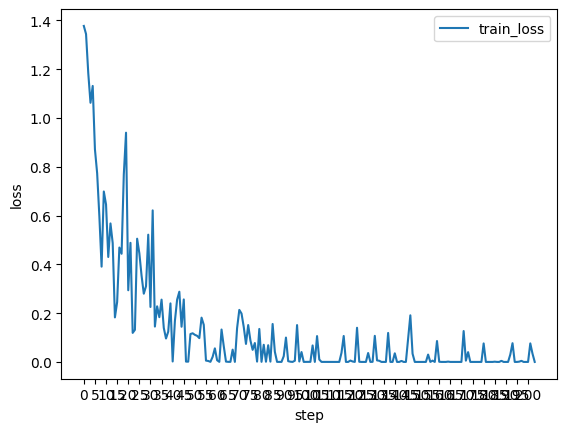

In [16]:
plot_loss(train_loss)

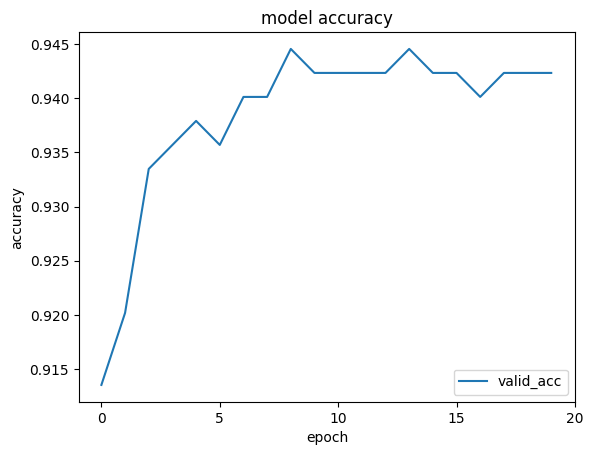

In [17]:
plot_metrics(eval_acc)

In [18]:
base_folder = CFG.MODEL_SAVE_PATH / 'omit'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [19]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_1,
    eval_dataset=val_dataset_1,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_1).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_1[i]["labels"].item() for i in range(len(val_dataset_1))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9445676274944568


# Measureの学習

In [20]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_meas'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'meas',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [21]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.462, 'grad_norm': 3.3613903522491455, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 1.0059, 'grad_norm': 11.193852424621582, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.6016, 'grad_norm': 32.27490997314453, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.5124, 'grad_norm': 3.262272834777832, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.4365, 'grad_norm': 15.189765930175781, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.6705, 'grad_norm': 6.772862911224365, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.6319, 'grad_norm': 16.316259384155273, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.7442, 'grad_norm': 4.884006023406982, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.7273, 'grad_norm': 6.830165863037109, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.3617, 'grad_norm': 9.80724811553955, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2767205834388733, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.941693146684988, 'eval_precision': 0.9415144016280675, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9076, 'eval_samples_per_second': 155.108, 'eval_steps_per_second': 31.297, 'epoch': 1.0}
{'loss': 0.4182, 'grad_norm': 3.0934011936187744, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.6922, 'grad_norm': 54.03760528564453, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.3736, 'grad_norm': 25.060131072998047, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.302, 'grad_norm': 2.0976297855377197, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.1181, 'grad_norm': 0.22141146659851074, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.4021, 'grad_norm': 0.17278596758842468, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.5947, 'grad_norm': 0.23156586289405823, 'learning_rate': 9.166666666666666e-06, 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2572486698627472, 'eval_accuracy': 0.9445676274944568, 'eval_f1': 0.945413764428542, 'eval_precision': 0.947243357273223, 'eval_recall': 0.9445676274944568, 'eval_runtime': 2.9246, 'eval_samples_per_second': 154.207, 'eval_steps_per_second': 31.115, 'epoch': 2.0}
{'loss': 0.4098, 'grad_norm': 7.901500225067139, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.1886, 'grad_norm': 0.41778433322906494, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.3163, 'grad_norm': 0.12967745959758759, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.3189, 'grad_norm': 11.692864418029785, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.4811, 'grad_norm': 17.65040397644043, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.2333, 'grad_norm': 0.23505234718322754, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.1524, 'grad_norm': 0.10557890683412552, 'learning_rate': 8.676470588235295e-06

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.19978737831115723, 'eval_accuracy': 0.9645232815964523, 'eval_f1': 0.9638281882550632, 'eval_precision': 0.9645721449454857, 'eval_recall': 0.9645232815964523, 'eval_runtime': 2.9155, 'eval_samples_per_second': 154.689, 'eval_steps_per_second': 31.212, 'epoch': 3.0}
{'loss': 0.4224, 'grad_norm': 1.2618180513381958, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.3229, 'grad_norm': 11.725262641906738, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.0986, 'grad_norm': 0.05199146643280983, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.3207, 'grad_norm': 0.07578352838754654, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.0365, 'grad_norm': 0.10188545286655426, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.1443, 'grad_norm': 0.04903411120176315, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.146, 'grad_norm': 0.03818468004465103, 'learning_rate': 8.186274509803922e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23034745454788208, 'eval_accuracy': 0.9645232815964523, 'eval_f1': 0.9642577589501214, 'eval_precision': 0.9642122571432692, 'eval_recall': 0.9645232815964523, 'eval_runtime': 2.9517, 'eval_samples_per_second': 152.796, 'eval_steps_per_second': 30.83, 'epoch': 4.0}
{'loss': 0.2116, 'grad_norm': 0.07844766974449158, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.0019, 'grad_norm': 0.05109115689992905, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.112, 'grad_norm': 0.07933711260557175, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.1096, 'grad_norm': 0.016204973682761192, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.2402, 'grad_norm': 0.047589149326086044, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.078, 'grad_norm': 0.061898961663246155, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0857, 'grad_norm': 0.033270400017499924, 'learning_rate': 7.69607843137

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.25740543007850647, 'eval_accuracy': 0.9534368070953437, 'eval_f1': 0.9528127688991119, 'eval_precision': 0.9528611348242586, 'eval_recall': 0.9534368070953437, 'eval_runtime': 2.8856, 'eval_samples_per_second': 156.292, 'eval_steps_per_second': 31.536, 'epoch': 5.0}
{'loss': 0.0022, 'grad_norm': 0.024792715907096863, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0898, 'grad_norm': 0.024620436131954193, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.3108, 'grad_norm': 0.03739413246512413, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.0018, 'grad_norm': 0.06055780127644539, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.133, 'grad_norm': 16.83867835998535, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.0781, 'grad_norm': 0.04600606858730316, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0816, 'grad_norm': 237.86399841308594, 'learning_rate': 7.1568627450980

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23134708404541016, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9614872931946102, 'eval_precision': 0.9624151716723779, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9537, 'eval_samples_per_second': 152.692, 'eval_steps_per_second': 30.809, 'epoch': 6.0}
{'loss': 0.0061, 'grad_norm': 0.015813369303941727, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.2882, 'grad_norm': 0.050657544285058975, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.0009, 'grad_norm': 0.08155982941389084, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.1569, 'grad_norm': 0.2396169751882553, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0007, 'grad_norm': 0.014377696439623833, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0645, 'grad_norm': 0.023057153448462486, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0236, 'grad_norm': 12.773609161376953, 'learning_rate': 6.6666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3454078137874603, 'eval_accuracy': 0.9556541019955654, 'eval_f1': 0.9541975639536615, 'eval_precision': 0.9565345155808813, 'eval_recall': 0.9556541019955654, 'eval_runtime': 2.9477, 'eval_samples_per_second': 153.003, 'eval_steps_per_second': 30.872, 'epoch': 7.0}
{'loss': 0.0308, 'grad_norm': 313.3056945800781, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0528, 'grad_norm': 93.3100814819336, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0009, 'grad_norm': 0.02326655387878418, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.0821, 'grad_norm': 0.028425082564353943, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.1829, 'grad_norm': 52.98340606689453, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0227, 'grad_norm': 0.013098795898258686, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.0008, 'grad_norm': 0.016646942123770714, 'learning_rate': 6.176470588235295e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2932696044445038, 'eval_accuracy': 0.9600886917960089, 'eval_f1': 0.9594726745611631, 'eval_precision': 0.9597546085350964, 'eval_recall': 0.9600886917960089, 'eval_runtime': 2.9236, 'eval_samples_per_second': 154.259, 'eval_steps_per_second': 31.125, 'epoch': 8.0}
{'loss': 0.0003, 'grad_norm': 0.011965323239564896, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0007, 'grad_norm': 0.01950180158019066, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0003, 'grad_norm': 0.0787019431591034, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.1443, 'grad_norm': 0.005677010864019394, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.1646, 'grad_norm': 0.006779191549867392, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0004, 'grad_norm': 0.009134490042924881, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0004, 'grad_norm': 0.05973857268691063, 'learning_rate': 5.686274509

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.30994147062301636, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9614872931946102, 'eval_precision': 0.9624151716723779, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9487, 'eval_samples_per_second': 152.951, 'eval_steps_per_second': 30.862, 'epoch': 9.0}
{'loss': 0.0003, 'grad_norm': 0.010384956374764442, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0003, 'grad_norm': 0.011692201718688011, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0003, 'grad_norm': 0.036667995154857635, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.0005, 'grad_norm': 0.19917656481266022, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0002, 'grad_norm': 0.0049062189646065235, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.001, 'grad_norm': 0.004328319802880287, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0003, 'grad_norm': 0.006856289692223072, 'learning_rate': 5.1960

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3167368769645691, 'eval_accuracy': 0.9600886917960089, 'eval_f1': 0.9594726745611631, 'eval_precision': 0.9597546085350964, 'eval_recall': 0.9600886917960089, 'eval_runtime': 2.8752, 'eval_samples_per_second': 156.861, 'eval_steps_per_second': 31.65, 'epoch': 10.0}
{'loss': 0.0002, 'grad_norm': 0.0046466318890452385, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0003, 'grad_norm': 0.003387887729331851, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0164, 'grad_norm': 0.004710560664534569, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0001, 'grad_norm': 0.00431505823507905, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0002, 'grad_norm': 0.004962240811437368, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0002, 'grad_norm': 0.010021986439824104, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0104, 'grad_norm': 0.003834259230643511, 'learning_rate': 4.

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.32205355167388916, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9377, 'eval_samples_per_second': 153.524, 'eval_steps_per_second': 30.977, 'epoch': 11.0}
{'loss': 0.0001, 'grad_norm': 0.003799173515290022, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0001, 'grad_norm': 0.004583082161843777, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0001, 'grad_norm': 0.0029930404853075743, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0001, 'grad_norm': 0.008590945973992348, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0002, 'grad_norm': 0.016962550580501556, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0001, 'grad_norm': 0.0023979952093213797, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0001, 'grad_norm': 0.017254794016480446, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.33452579379081726, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9336, 'eval_samples_per_second': 153.733, 'eval_steps_per_second': 31.019, 'epoch': 12.0}
{'loss': 0.0001, 'grad_norm': 0.005327255930751562, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0001, 'grad_norm': 0.002908216090872884, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0001, 'grad_norm': 0.003796529257670045, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0001, 'grad_norm': 0.0024756724014878273, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0002, 'grad_norm': 0.0026978421956300735, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0001, 'grad_norm': 0.0033799530938267708, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0001, 'grad_norm': 0.002702554455026984, 'learning_ra

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3484521210193634, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9507, 'eval_samples_per_second': 152.848, 'eval_steps_per_second': 30.841, 'epoch': 13.0}
{'loss': 0.0001, 'grad_norm': 0.002734667621552944, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0001, 'grad_norm': 0.004426882136613131, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0001, 'grad_norm': 0.0030498108826577663, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0001, 'grad_norm': 0.0048856427893042564, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0001, 'grad_norm': 0.0025967091787606478, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0001, 'grad_norm': 0.002305652480572462, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0001, 'grad_norm': 0.003444894915446639, 'learning_r

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.35295215249061584, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9507, 'eval_samples_per_second': 152.848, 'eval_steps_per_second': 30.841, 'epoch': 14.0}
{'loss': 0.0001, 'grad_norm': 0.0037041837349534035, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0001, 'grad_norm': 0.0018161007901653647, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0001, 'grad_norm': 0.03055627830326557, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0001, 'grad_norm': 0.0021276921033859253, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0001, 'grad_norm': 0.0021492582745850086, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0001, 'grad_norm': 0.001904214615933597, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0001, 'grad_norm': 0.0040213847532868385, 'learnin

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3582189977169037, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9018, 'eval_samples_per_second': 155.419, 'eval_steps_per_second': 31.36, 'epoch': 15.0}
{'loss': 0.0001, 'grad_norm': 0.006803417112678289, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0001, 'grad_norm': 0.004130352288484573, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0001, 'grad_norm': 0.001820495119318366, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0001, 'grad_norm': 0.0017694858834147453, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0001, 'grad_norm': 0.002466367557644844, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0001, 'grad_norm': 0.001222390914335847, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0001, 'grad_norm': 0.0035927563440054655, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3656941056251526, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9547, 'eval_samples_per_second': 152.641, 'eval_steps_per_second': 30.799, 'epoch': 16.0}
{'loss': 0.0001, 'grad_norm': 0.0020136854145675898, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0001, 'grad_norm': 0.006850613281130791, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0001, 'grad_norm': 0.0018245517276227474, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0001, 'grad_norm': 0.0018942084861919284, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0001, 'grad_norm': 0.0019625250715762377, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0001, 'grad_norm': 0.0016188952140510082, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0001, 'grad_norm': 0.0021037922706454992, 'learnin

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.36827027797698975, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9557, 'eval_samples_per_second': 152.589, 'eval_steps_per_second': 30.788, 'epoch': 17.0}
{'loss': 0.0001, 'grad_norm': 0.0016044549411162734, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0001, 'grad_norm': 0.0023038757499307394, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0001, 'grad_norm': 0.001571742002852261, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0001, 'grad_norm': 0.0037844046019017696, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0001, 'grad_norm': 0.0018344591371715069, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0001, 'grad_norm': 0.001684047281742096, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0001, 'grad_norm': 0.001667205011472106, 'learni

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.37062662839889526, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9616464106937201, 'eval_precision': 0.9621376933990947, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9577, 'eval_samples_per_second': 152.486, 'eval_steps_per_second': 30.768, 'epoch': 18.0}
{'loss': 0.0001, 'grad_norm': 0.0014586597681045532, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0001, 'grad_norm': 0.0021363133564591408, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0001, 'grad_norm': 0.010228779166936874, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0001, 'grad_norm': 0.0015299076912924647, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0001, 'grad_norm': 0.0024906639009714127, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0001, 'grad_norm': 0.0017740897601470351, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0002, 'grad_norm': 0.002652933355420828, 'learning_ra

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3531723618507385, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9660181998775974, 'eval_precision': 0.9670597325807968, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.9507, 'eval_samples_per_second': 152.848, 'eval_steps_per_second': 30.841, 'epoch': 19.0}
{'loss': 0.0001, 'grad_norm': 0.002026152331382036, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0017131316708400846, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0001, 'grad_norm': 0.0018183161737397313, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0001, 'grad_norm': 0.0015512759564444423, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0001, 'grad_norm': 0.0017811536090448499, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0001, 'grad_norm': 0.0023601949214935303, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0001, 'grad_norm': 0.0020612848456948996, 'learni

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3533766269683838, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9660181998775974, 'eval_precision': 0.9670597325807968, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.8932, 'eval_samples_per_second': 155.883, 'eval_steps_per_second': 31.453, 'epoch': 20.0}
{'train_runtime': 729.5104, 'train_samples_per_second': 27.964, 'train_steps_per_second': 2.796, 'train_loss': 0.10106529310099123, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.10106529310099123, metrics={'train_runtime': 729.5104, 'train_samples_per_second': 27.964, 'train_steps_per_second': 2.796, 'total_flos': 1211491648358220.0, 'train_loss': 0.10106529310099123, 'epoch': 20.0})

In [23]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


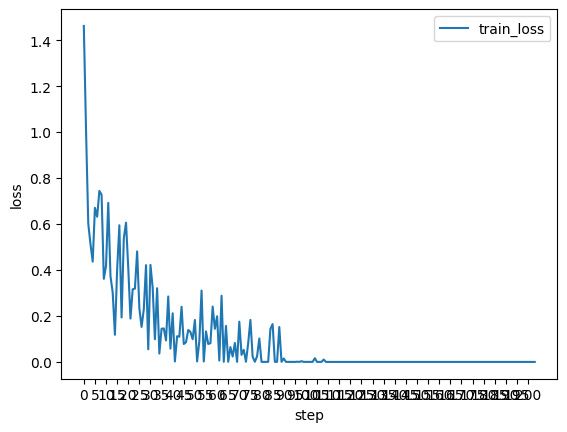

In [24]:
plot_loss(train_loss)

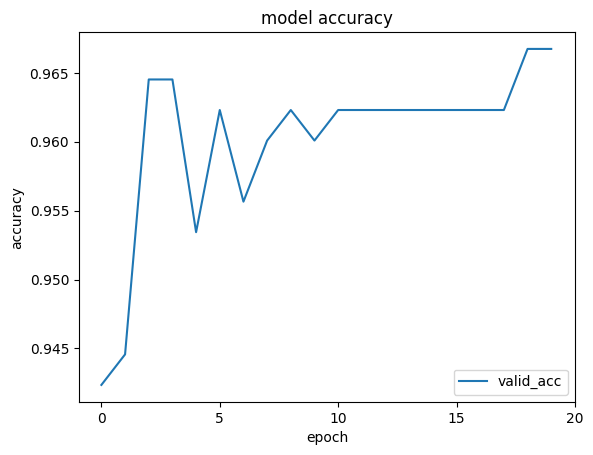

In [25]:
plot_metrics(eval_acc)

In [26]:
base_folder = CFG.MODEL_SAVE_PATH / 'meas'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [27]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_2).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_2[i]["labels"].item() for i in range(len(val_dataset_2))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9667405764966741


# Extensionの学習

In [28]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_exte'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'exte',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [29]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_3,
    eval_dataset=val_dataset_3,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.469, 'grad_norm': 12.910185813903809, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.8066, 'grad_norm': 13.416626930236816, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.7257, 'grad_norm': 9.778810501098633, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.7033, 'grad_norm': 4.58929967880249, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.3819, 'grad_norm': 11.816617965698242, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.5032, 'grad_norm': 21.462013244628906, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.5531, 'grad_norm': 0.7174618244171143, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.2699, 'grad_norm': 18.145694732666016, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.5255, 'grad_norm': 2.204482078552246, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.552, 'grad_norm': 3.440887212753296, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.1648610681295395, 'eval_accuracy': 0.9534368070953437, 'eval_f1': 0.9498730094738963, 'eval_precision': 0.9510032068752018, 'eval_recall': 0.9534368070953437, 'eval_runtime': 2.9577, 'eval_samples_per_second': 152.486, 'eval_steps_per_second': 30.768, 'epoch': 1.0}
{'loss': 0.5469, 'grad_norm': 14.218213081359863, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.4926, 'grad_norm': 1.7803723812103271, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.1689, 'grad_norm': 0.20024733245372772, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.0859, 'grad_norm': 1.8842490911483765, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.3064, 'grad_norm': 1.3590108156204224, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.282, 'grad_norm': 2.967338800430298, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.2003, 'grad_norm': 8.978316307067871, 'learning_rate': 9.166666666666666e-06, 'e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.13783937692642212, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9654802049747685, 'eval_precision': 0.9655201742188535, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.9907, 'eval_samples_per_second': 150.803, 'eval_steps_per_second': 30.428, 'epoch': 2.0}
{'loss': 0.1831, 'grad_norm': 0.27847760915756226, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.2825, 'grad_norm': 288.0699157714844, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.2042, 'grad_norm': 0.16882073879241943, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.186, 'grad_norm': 0.0628938376903534, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.2347, 'grad_norm': 0.06722038984298706, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.2634, 'grad_norm': 0.03937199339270592, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.1793, 'grad_norm': 0.8769249320030212, 'learning_rate': 8.676470588235295e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.12325513362884521, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.965075129657287, 'eval_precision': 0.9656546362834932, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.9707, 'eval_samples_per_second': 151.818, 'eval_steps_per_second': 30.633, 'epoch': 3.0}
{'loss': 0.4261, 'grad_norm': 16.556116104125977, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.2227, 'grad_norm': 0.05587483569979668, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.2708, 'grad_norm': 0.11346212774515152, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.6078, 'grad_norm': 278.0001220703125, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.1406, 'grad_norm': 0.069046251475811, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.3249, 'grad_norm': 6.494490623474121, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.1437, 'grad_norm': 0.04221220687031746, 'learning_rate': 8.186274509803922e-06, 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.17422573268413544, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9635021929454045, 'eval_precision': 0.9656932712131685, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9767, 'eval_samples_per_second': 151.512, 'eval_steps_per_second': 30.571, 'epoch': 4.0}
{'loss': 0.0123, 'grad_norm': 0.04051744565367699, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.0246, 'grad_norm': 0.02324904315173626, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.3606, 'grad_norm': 151.53794860839844, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.1914, 'grad_norm': 0.01966750994324684, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.0484, 'grad_norm': 0.035503726452589035, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.3401, 'grad_norm': 0.16903802752494812, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0829, 'grad_norm': 0.015858855098485947, 'learning_rate': 7.69607843137

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.17824438214302063, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9692569622226745, 'eval_precision': 0.969646834948155, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.8946, 'eval_samples_per_second': 155.805, 'eval_steps_per_second': 31.437, 'epoch': 5.0}
{'loss': 0.1295, 'grad_norm': 0.03905192390084267, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0257, 'grad_norm': 0.935309886932373, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.1345, 'grad_norm': 0.033889930695295334, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.1128, 'grad_norm': 0.03721345588564873, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0013, 'grad_norm': 0.10198528319597244, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.0025, 'grad_norm': 0.04352102801203728, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0009, 'grad_norm': 0.054065391421318054, 'learning_rate': 7.156862745098

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.1936485469341278, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9677960525988862, 'eval_precision': 0.969868278918343, 'eval_recall': 0.9667405764966741, 'eval_runtime': 3.0107, 'eval_samples_per_second': 149.801, 'eval_steps_per_second': 30.226, 'epoch': 6.0}
{'loss': 0.0037, 'grad_norm': 0.016747329384088516, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.0009, 'grad_norm': 0.07639287412166595, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.1252, 'grad_norm': 0.005251958500593901, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0008, 'grad_norm': 0.02809341624379158, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0244, 'grad_norm': 0.004837768152356148, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0005, 'grad_norm': 0.021854320541024208, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.4611, 'grad_norm': 0.022142359986901283, 'learning_rate': 6.666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.18496061861515045, 'eval_accuracy': 0.9600886917960089, 'eval_f1': 0.961519161061519, 'eval_precision': 0.9642167663822185, 'eval_recall': 0.9600886917960089, 'eval_runtime': 2.9827, 'eval_samples_per_second': 151.207, 'eval_steps_per_second': 30.51, 'epoch': 7.0}
{'loss': 0.0042, 'grad_norm': 0.07232721894979477, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0007, 'grad_norm': 0.024784836918115616, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0007, 'grad_norm': 0.006858233828097582, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.1028, 'grad_norm': 0.026523655280470848, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.0009, 'grad_norm': 0.006567192729562521, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0006, 'grad_norm': 0.006359145510941744, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.0031, 'grad_norm': 0.015074328519403934, 'learning_rate': 6.1764705

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2346998006105423, 'eval_accuracy': 0.9623059866962306, 'eval_f1': 0.9638081142500545, 'eval_precision': 0.9669090611217539, 'eval_recall': 0.9623059866962306, 'eval_runtime': 2.9637, 'eval_samples_per_second': 152.177, 'eval_steps_per_second': 30.705, 'epoch': 8.0}
{'loss': 0.0007, 'grad_norm': 0.004819271620362997, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0008, 'grad_norm': 0.028169827535748482, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0006, 'grad_norm': 0.10718817263841629, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.1025, 'grad_norm': 0.027781717479228973, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0006, 'grad_norm': 0.028909049928188324, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0007, 'grad_norm': 0.01271376758813858, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0974, 'grad_norm': 0.04355480149388313, 'learning_rate': 5.68627450

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.27869588136672974, 'eval_accuracy': 0.9578713968957872, 'eval_f1': 0.9598762561923498, 'eval_precision': 0.9641575081294129, 'eval_recall': 0.9578713968957872, 'eval_runtime': 2.9396, 'eval_samples_per_second': 153.42, 'eval_steps_per_second': 30.956, 'epoch': 9.0}
{'loss': 0.1274, 'grad_norm': 0.005815498530864716, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0008, 'grad_norm': 0.016319014132022858, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0005, 'grad_norm': 0.014559143222868443, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.1321, 'grad_norm': 0.03745492175221443, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0009, 'grad_norm': 0.018152570351958275, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.0008, 'grad_norm': 0.020026370882987976, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.1033, 'grad_norm': 8.239766120910645, 'learning_rate': 5.19607843

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.18935203552246094, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9757287312849552, 'eval_precision': 0.9758715944647369, 'eval_recall': 0.975609756097561, 'eval_runtime': 2.8964, 'eval_samples_per_second': 155.709, 'eval_steps_per_second': 31.418, 'epoch': 10.0}
{'loss': 0.0004, 'grad_norm': 0.012643815949559212, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0005, 'grad_norm': 0.012374529615044594, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0003, 'grad_norm': 0.002810470061376691, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0005, 'grad_norm': 0.021376948803663254, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0004, 'grad_norm': 0.0027338690124452114, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0003, 'grad_norm': 0.010342649184167385, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0003, 'grad_norm': 0.0068377116695046425, 'learning_rate': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23882396519184113, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9675127903339652, 'eval_precision': 0.9688196360539892, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.9637, 'eval_samples_per_second': 152.176, 'eval_steps_per_second': 30.705, 'epoch': 11.0}
{'loss': 0.0003, 'grad_norm': 0.0032897412311285734, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0006, 'grad_norm': 0.02328561060130596, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0951, 'grad_norm': 0.005003075581043959, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.1356, 'grad_norm': 0.0038583879359066486, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0467, 'grad_norm': 0.01104150339961052, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0006, 'grad_norm': 0.042518358677625656, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0008, 'grad_norm': 0.02412867732346058, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23438918590545654, 'eval_accuracy': 0.9645232815964523, 'eval_f1': 0.9654998817075923, 'eval_precision': 0.9672264249380462, 'eval_recall': 0.9645232815964523, 'eval_runtime': 2.9547, 'eval_samples_per_second': 152.641, 'eval_steps_per_second': 30.799, 'epoch': 12.0}
{'loss': 0.0006, 'grad_norm': 0.003096641506999731, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0003, 'grad_norm': 0.01281875278800726, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.1099, 'grad_norm': 28.81920623779297, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0005, 'grad_norm': 0.002709032269194722, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0003, 'grad_norm': 0.02901635318994522, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0008, 'grad_norm': 0.012056580744683743, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0003, 'grad_norm': 0.002442181808874011, 'learning_rate': 3.6

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.24067899584770203, 'eval_accuracy': 0.9667405764966741, 'eval_f1': 0.9675127903339652, 'eval_precision': 0.9688196360539892, 'eval_recall': 0.9667405764966741, 'eval_runtime': 2.9687, 'eval_samples_per_second': 151.921, 'eval_steps_per_second': 30.654, 'epoch': 13.0}
{'loss': 0.0005, 'grad_norm': 0.01122599933296442, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0003, 'grad_norm': 0.007612242363393307, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0006, 'grad_norm': 0.01526485662907362, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.1308, 'grad_norm': 0.0019424700876697898, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0009, 'grad_norm': 0.04122581332921982, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0003, 'grad_norm': 0.016537843272089958, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0006, 'grad_norm': 0.00195537437684834, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.20757178962230682, 'eval_accuracy': 0.9711751662971175, 'eval_f1': 0.9715866376662164, 'eval_precision': 0.9722012841603714, 'eval_recall': 0.9711751662971175, 'eval_runtime': 2.9567, 'eval_samples_per_second': 152.537, 'eval_steps_per_second': 30.778, 'epoch': 14.0}
{'loss': 0.0005, 'grad_norm': 0.015689752995967865, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.08, 'grad_norm': 0.026035403832793236, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0007, 'grad_norm': 0.008836152963340282, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0002, 'grad_norm': 0.00405711168423295, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0012, 'grad_norm': 0.006793116685003042, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0009, 'grad_norm': 0.0019311560317873955, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0002, 'grad_norm': 0.0017975909868255258, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2293562889099121, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.8986, 'eval_samples_per_second': 155.59, 'eval_steps_per_second': 31.394, 'epoch': 15.0}
{'loss': 0.0003, 'grad_norm': 0.11003381013870239, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0002, 'grad_norm': 0.013411667197942734, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0003, 'grad_norm': 0.006396403536200523, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0003, 'grad_norm': 0.010786601342260838, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0003, 'grad_norm': 0.006715654861181974, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0002, 'grad_norm': 0.001371153979562223, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0003, 'grad_norm': 0.09169077128171921, 'learning_rate': 2.1

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23464305698871613, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.9597, 'eval_samples_per_second': 152.383, 'eval_steps_per_second': 30.747, 'epoch': 16.0}
{'loss': 0.0005, 'grad_norm': 0.14780612289905548, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0902, 'grad_norm': 0.0029313289560377598, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0002, 'grad_norm': 0.01570480316877365, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0002, 'grad_norm': 0.0015524731716141105, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0004, 'grad_norm': 0.0088227279484272, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0002, 'grad_norm': 0.0017002099193632603, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0003, 'grad_norm': 0.005093311425298452, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23913106322288513, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.9627, 'eval_samples_per_second': 152.228, 'eval_steps_per_second': 30.716, 'epoch': 17.0}
{'loss': 0.0002, 'grad_norm': 0.004114971961826086, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0002, 'grad_norm': 0.010107995942234993, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0004, 'grad_norm': 0.01594124361872673, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0001, 'grad_norm': 0.001311317551881075, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0002, 'grad_norm': 0.0019683053251355886, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0005, 'grad_norm': 0.006863494403660297, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0002, 'grad_norm': 0.007564546540379524, 'learning_r

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.24336357414722443, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.9807, 'eval_samples_per_second': 151.309, 'eval_steps_per_second': 30.53, 'epoch': 18.0}
{'loss': 0.0002, 'grad_norm': 0.01111300103366375, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0002, 'grad_norm': 0.031775183975696564, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0007, 'grad_norm': 0.0013588147703558207, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0005, 'grad_norm': 0.005184897221624851, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0929, 'grad_norm': 0.0039395601488649845, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0003, 'grad_norm': 0.0034987609833478928, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0002, 'grad_norm': 0.004530417732894421, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.242860808968544, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 2.9617, 'eval_samples_per_second': 152.28, 'eval_steps_per_second': 30.726, 'epoch': 19.0}
{'loss': 0.0002, 'grad_norm': 0.008607073687016964, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.003070197766646743, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0001, 'grad_norm': 0.0041447230614721775, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0005, 'grad_norm': 0.01787186600267887, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0001, 'grad_norm': 0.011561288498342037, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0985, 'grad_norm': 0.013147160410881042, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0009, 'grad_norm': 0.004921833518892527, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.24340665340423584, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9695415052662506, 'eval_precision': 0.9704765912056983, 'eval_recall': 0.9689578713968958, 'eval_runtime': 3.0906, 'eval_samples_per_second': 145.928, 'eval_steps_per_second': 29.444, 'epoch': 20.0}
{'train_runtime': 731.5558, 'train_samples_per_second': 27.886, 'train_steps_per_second': 2.789, 'train_loss': 0.09909147120533995, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.09909147120533995, metrics={'train_runtime': 731.5558, 'train_samples_per_second': 27.886, 'train_steps_per_second': 2.789, 'total_flos': 1211491648358220.0, 'train_loss': 0.09909147120533995, 'epoch': 20.0})

In [31]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


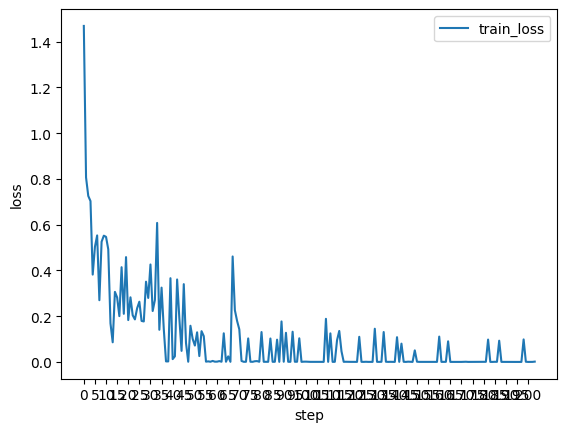

In [32]:
plot_loss(train_loss)

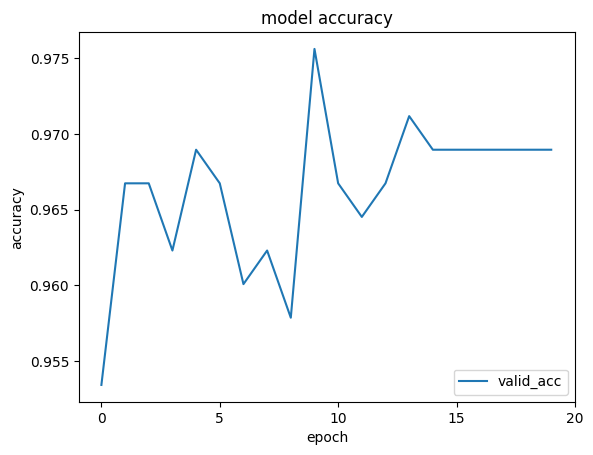

In [33]:
plot_metrics(eval_acc)

In [34]:
base_folder = CFG.MODEL_SAVE_PATH / 'exte'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [35]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_3,
    eval_dataset=val_dataset_3,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_3).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_3[i]["labels"].item() for i in range(len(val_dataset_3))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.975609756097561


# Atelectasisの学習

In [36]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_atel'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'atel',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [37]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_4,
    eval_dataset=val_dataset_4,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.4424, 'grad_norm': 16.12006950378418, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.4012, 'grad_norm': 2.5269370079040527, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.3334, 'grad_norm': 8.343856811523438, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.6651, 'grad_norm': 2.6819369792938232, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.406, 'grad_norm': 0.35771259665489197, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.0081, 'grad_norm': 0.18071556091308594, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.2447, 'grad_norm': 0.17702774703502655, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.2621, 'grad_norm': 7.0561652183532715, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.2586, 'grad_norm': 0.21316218376159668, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.575, 'grad_norm': 0.23228944838047028, 'learni

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.207692489027977, 'eval_accuracy': 0.9600886917960089, 'eval_f1': 0.940539374542244, 'eval_precision': 0.9217702961145716, 'eval_recall': 0.9600886917960089, 'eval_runtime': 2.9607, 'eval_samples_per_second': 152.331, 'eval_steps_per_second': 30.736, 'epoch': 1.0}
{'loss': 0.7938, 'grad_norm': 7.45892333984375, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.1135, 'grad_norm': 0.2009991556406021, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.3421, 'grad_norm': 14.87066650390625, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.1655, 'grad_norm': 0.11099810898303986, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.4929, 'grad_norm': 7.988436222076416, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.2507, 'grad_norm': 0.2668550908565521, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.2653, 'grad_norm': 0.2799881398677826, 'learning_rate': 9.166666666666666e-06, 'epoc

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.08456926047801971, 'eval_accuracy': 0.9600886917960089, 'eval_f1': 0.940539374542244, 'eval_precision': 0.9217702961145716, 'eval_recall': 0.9600886917960089, 'eval_runtime': 2.9832, 'eval_samples_per_second': 151.179, 'eval_steps_per_second': 30.504, 'epoch': 2.0}
{'loss': 0.1771, 'grad_norm': 0.2003639042377472, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.2178, 'grad_norm': 8.580623626708984, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.1716, 'grad_norm': 0.09841307252645493, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.0116, 'grad_norm': 0.11408695578575134, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.2422, 'grad_norm': 1.510131597518921, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.0606, 'grad_norm': 0.044144295156002045, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.0039, 'grad_norm': 0.16180332005023956, 'learning_rate': 8.676470588235295e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.09382493793964386, 'eval_accuracy': 0.9711751662971175, 'eval_f1': 0.9739062940645319, 'eval_precision': 0.9792111171540532, 'eval_recall': 0.9711751662971175, 'eval_runtime': 2.9712, 'eval_samples_per_second': 151.791, 'eval_steps_per_second': 30.627, 'epoch': 3.0}
{'loss': 0.1586, 'grad_norm': 0.2816784679889679, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.0041, 'grad_norm': 0.03591161593794823, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.1905, 'grad_norm': 0.049529846757650375, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.002, 'grad_norm': 0.041754815727472305, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.1591, 'grad_norm': 0.03926753252744675, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.0013, 'grad_norm': 0.03691287338733673, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.0011, 'grad_norm': 0.033928096294403076, 'learning_rate': 8.186274509803

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06214957311749458, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9866962305986696, 'eval_precision': 0.9866962305986696, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9837, 'eval_samples_per_second': 151.157, 'eval_steps_per_second': 30.499, 'epoch': 4.0}
{'loss': 0.505, 'grad_norm': 0.2584943175315857, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.0393, 'grad_norm': 0.11099305003881454, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.0091, 'grad_norm': 0.08017461746931076, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.0016, 'grad_norm': 0.02798803523182869, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.1422, 'grad_norm': 0.03177754208445549, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.14, 'grad_norm': 0.045521970838308334, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0031, 'grad_norm': 0.03614715486764908, 'learning_rate': 7.69607843137255e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06829515844583511, 'eval_accuracy': 0.9844789356984479, 'eval_f1': 0.9850489221938789, 'eval_precision': 0.9860317787714272, 'eval_recall': 0.9844789356984479, 'eval_runtime': 2.9086, 'eval_samples_per_second': 155.055, 'eval_steps_per_second': 31.286, 'epoch': 5.0}
{'loss': 0.0018, 'grad_norm': 0.027147730812430382, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.1097, 'grad_norm': 0.13376769423484802, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.001, 'grad_norm': 0.02498643659055233, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.2074, 'grad_norm': 19.7268123626709, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0009, 'grad_norm': 0.029756881296634674, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.1238, 'grad_norm': 11.594096183776855, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0005, 'grad_norm': 0.02383463829755783, 'learning_rate': 7.15686274509804

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06576601415872574, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9863202701866097, 'eval_precision': 0.9861826847108596, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9931, 'eval_samples_per_second': 150.682, 'eval_steps_per_second': 30.404, 'epoch': 6.0}
{'loss': 0.0556, 'grad_norm': 0.022241581231355667, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.0016, 'grad_norm': 0.016078313812613487, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.0507, 'grad_norm': 0.015171105973422527, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0015, 'grad_norm': 0.0892738550901413, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0007, 'grad_norm': 0.011833217926323414, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0013, 'grad_norm': 0.4899570345878601, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0006, 'grad_norm': 0.006887851748615503, 'learning_rate': 6.666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06253847479820251, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9890569343551155, 'eval_precision': 0.9892533594394954, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9807, 'eval_samples_per_second': 151.309, 'eval_steps_per_second': 30.53, 'epoch': 7.0}
{'loss': 0.0005, 'grad_norm': 0.373121976852417, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0003, 'grad_norm': 0.008760022930800915, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0004, 'grad_norm': 0.006214645691215992, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.0006, 'grad_norm': 0.006137925200164318, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.0004, 'grad_norm': 0.00704974727705121, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0003, 'grad_norm': 0.005230476148426533, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.0002, 'grad_norm': 0.005273896735161543, 'learning_rate': 6.176470588

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.048907388001680374, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9890569343551155, 'eval_precision': 0.9892533594394954, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9767, 'eval_samples_per_second': 151.512, 'eval_steps_per_second': 30.571, 'epoch': 8.0}
{'loss': 0.0013, 'grad_norm': 0.008172943256795406, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0002, 'grad_norm': 0.005582757294178009, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0004, 'grad_norm': 0.009377565234899521, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.0004, 'grad_norm': 0.010076511651277542, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0002, 'grad_norm': 0.004969556350260973, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0002, 'grad_norm': 0.004559081047773361, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0005, 'grad_norm': 0.00406944053247571, 'learning_rate': 5.6862

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.05141152814030647, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9887615408756433, 'eval_precision': 0.9886679941986092, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9624, 'eval_samples_per_second': 152.242, 'eval_steps_per_second': 30.719, 'epoch': 9.0}
{'loss': 0.0812, 'grad_norm': 0.010118327103555202, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0003, 'grad_norm': 0.013488605618476868, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0002, 'grad_norm': 0.008769401349127293, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.0003, 'grad_norm': 0.024337509647011757, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0003, 'grad_norm': 0.005368194542825222, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.0002, 'grad_norm': 0.004258289001882076, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0016, 'grad_norm': 0.5314257740974426, 'learning_rate': 5.19607

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.05702789127826691, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9887615408756433, 'eval_precision': 0.9886679941986092, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9129, 'eval_samples_per_second': 154.83, 'eval_steps_per_second': 31.241, 'epoch': 10.0}
{'loss': 0.0002, 'grad_norm': 0.004612423945218325, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0003, 'grad_norm': 0.004175382666289806, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0002, 'grad_norm': 0.0036209076642990112, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0002, 'grad_norm': 0.005701509770005941, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0595, 'grad_norm': 0.00486742751672864, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0007, 'grad_norm': 0.005138951353728771, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0001, 'grad_norm': 0.004608769901096821, 'learning_rate': 4

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06388511508703232, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9887615408756433, 'eval_precision': 0.9886679941986092, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9616, 'eval_samples_per_second': 152.285, 'eval_steps_per_second': 30.727, 'epoch': 11.0}
{'loss': 0.0001, 'grad_norm': 0.005384377669543028, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0139, 'grad_norm': 0.016016526147723198, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0006, 'grad_norm': 0.004197159316390753, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0003, 'grad_norm': 0.003928938880562782, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.123, 'grad_norm': 0.007961390540003777, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0001, 'grad_norm': 0.005300672259181738, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0001, 'grad_norm': 0.00665435241535306, 'learning_rate': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.060218602418899536, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9887615408756433, 'eval_precision': 0.9886679941986092, 'eval_recall': 0.9889135254988913, 'eval_runtime': 2.9579, 'eval_samples_per_second': 152.471, 'eval_steps_per_second': 30.765, 'epoch': 12.0}
{'loss': 0.0029, 'grad_norm': 0.0030075698159635067, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0001, 'grad_norm': 0.0026726401410996914, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0005, 'grad_norm': 0.25796616077423096, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0003, 'grad_norm': 0.0026651769876480103, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0004, 'grad_norm': 0.016683991998434067, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.1007, 'grad_norm': 0.0063409567810595036, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0002, 'grad_norm': 0.021785715594887733, 'learning_r

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06348885595798492, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9866962305986696, 'eval_precision': 0.9866962305986696, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.981, 'eval_samples_per_second': 151.292, 'eval_steps_per_second': 30.527, 'epoch': 13.0}
{'loss': 0.0018, 'grad_norm': 0.00483122281730175, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0001, 'grad_norm': 0.008685083128511906, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0001, 'grad_norm': 0.002295601647347212, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0001, 'grad_norm': 0.002324802801012993, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0003, 'grad_norm': 0.002804841846227646, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0001, 'grad_norm': 0.0038396480958908796, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0008, 'grad_norm': 0.0025987043045461178, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06775479763746262, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9870309319121898, 'eval_precision': 0.9875625704158327, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9628, 'eval_samples_per_second': 152.222, 'eval_steps_per_second': 30.714, 'epoch': 14.0}
{'loss': 0.0001, 'grad_norm': 0.03700072318315506, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0005, 'grad_norm': 0.002629328053444624, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0001, 'grad_norm': 0.005515821743756533, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0001, 'grad_norm': 0.0022693276405334473, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0002, 'grad_norm': 0.008238295093178749, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0004, 'grad_norm': 0.00241576018743217, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0001, 'grad_norm': 0.0024917535483837128, 'learning_ra

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06076647341251373, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9866962305986696, 'eval_precision': 0.9866962305986696, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.8976, 'eval_samples_per_second': 155.644, 'eval_steps_per_second': 31.405, 'epoch': 15.0}
{'loss': 0.0761, 'grad_norm': 9.411056518554688, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0001, 'grad_norm': 0.0028452323749661446, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0018, 'grad_norm': 0.007093640975654125, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0002, 'grad_norm': 0.0022921795025467873, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0001, 'grad_norm': 0.002383067272603512, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0001, 'grad_norm': 0.004154886119067669, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0005, 'grad_norm': 0.786731481552124, 'learning_rate': 2.1

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06247326731681824, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9866962305986696, 'eval_precision': 0.9866962305986696, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9652, 'eval_samples_per_second': 152.1, 'eval_steps_per_second': 30.69, 'epoch': 16.0}
{'loss': 0.0002, 'grad_norm': 0.025871992111206055, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0004, 'grad_norm': 0.005975763779133558, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0001, 'grad_norm': 0.0029835698660463095, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0001, 'grad_norm': 0.0018561907345429063, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0003, 'grad_norm': 0.0018803077982738614, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0001, 'grad_norm': 0.0018004666781052947, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0001, 'grad_norm': 0.002286347560584545, 'learning_ra

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06328102946281433, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9866962305986696, 'eval_precision': 0.9866962305986696, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9607, 'eval_samples_per_second': 152.331, 'eval_steps_per_second': 30.736, 'epoch': 17.0}
{'loss': 0.0001, 'grad_norm': 0.0019188027363270521, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0001, 'grad_norm': 0.0018092240206897259, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0009, 'grad_norm': 0.0019704457372426987, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0001, 'grad_norm': 0.0019108107080683112, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0001, 'grad_norm': 0.003983351401984692, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0004, 'grad_norm': 0.0016635868232697248, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0001, 'grad_norm': 0.0019215649226680398, 'lear

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06433761119842529, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9870309319121898, 'eval_precision': 0.9875625704158327, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9847, 'eval_samples_per_second': 151.106, 'eval_steps_per_second': 30.489, 'epoch': 18.0}
{'loss': 0.0004, 'grad_norm': 0.0016210085013881326, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0001, 'grad_norm': 0.008489551953971386, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0738, 'grad_norm': 0.002071850933134556, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0007, 'grad_norm': 0.002696712501347065, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0007, 'grad_norm': 0.0023433882743120193, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0006, 'grad_norm': 0.0018269156571477652, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0001, 'grad_norm': 0.00168436742387712, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06422873586416245, 'eval_accuracy': 0.9866962305986696, 'eval_f1': 0.9870309319121898, 'eval_precision': 0.9875625704158327, 'eval_recall': 0.9866962305986696, 'eval_runtime': 2.9877, 'eval_samples_per_second': 150.954, 'eval_steps_per_second': 30.459, 'epoch': 19.0}
{'loss': 0.0001, 'grad_norm': 0.00232512759976089, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0018735501216724515, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0001, 'grad_norm': 0.002546636387705803, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0756, 'grad_norm': 0.005929572973400354, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0001, 'grad_norm': 0.0055285063572227955, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0005, 'grad_norm': 0.0038207215256989002, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0009, 'grad_norm': 0.005690294783562422, 'learning_

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06360428780317307, 'eval_accuracy': 0.9889135254988913, 'eval_f1': 0.9890569343551155, 'eval_precision': 0.9892533594394954, 'eval_recall': 0.9889135254988913, 'eval_runtime': 3.011, 'eval_samples_per_second': 149.783, 'eval_steps_per_second': 30.222, 'epoch': 20.0}
{'train_runtime': 734.3013, 'train_samples_per_second': 27.782, 'train_steps_per_second': 2.778, 'train_loss': 0.06694939495115677, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.06694939495115677, metrics={'train_runtime': 734.3013, 'train_samples_per_second': 27.782, 'train_steps_per_second': 2.778, 'total_flos': 1211491648358220.0, 'train_loss': 0.06694939495115677, 'epoch': 20.0})

In [39]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


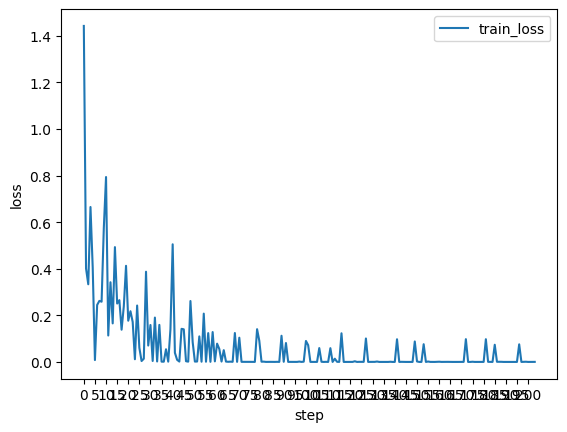

In [40]:
plot_loss(train_loss)

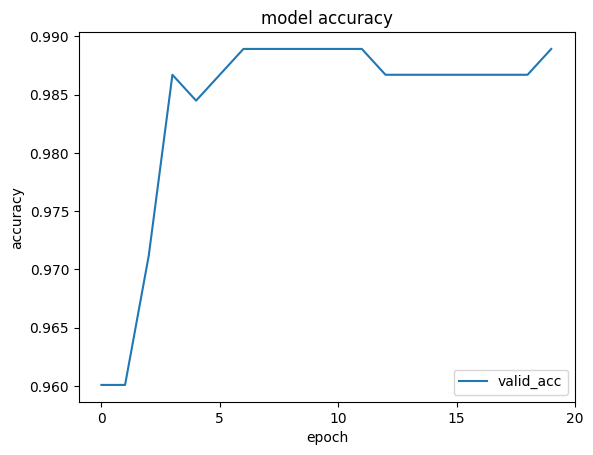

In [41]:
plot_metrics(eval_acc)

In [42]:
base_folder = CFG.MODEL_SAVE_PATH / 'atel'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [43]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_4,
    eval_dataset=val_dataset_4,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_4).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_4[i]["labels"].item() for i in range(len(val_dataset_4))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9889135254988913


# Satelliteの学習

In [44]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_sate'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'sate',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [45]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [46]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_5,
    eval_dataset=val_dataset_5,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.461, 'grad_norm': 9.453765869140625, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.5244, 'grad_norm': 2.982573986053467, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.4897, 'grad_norm': 8.031570434570312, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.7049, 'grad_norm': 6.475041389465332, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.3592, 'grad_norm': 0.5667377710342407, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.5121, 'grad_norm': 0.44983869791030884, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 1.4595, 'grad_norm': 25.722009658813477, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.5251, 'grad_norm': 3.000596046447754, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.4409, 'grad_norm': 1.9775636196136475, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.567, 'grad_norm': 13.460618019104004, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.32578393816947937, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9013659757114668, 'eval_precision': 0.8713870629937907, 'eval_recall': 0.9334811529933481, 'eval_runtime': 2.6646, 'eval_samples_per_second': 169.256, 'eval_steps_per_second': 34.151, 'epoch': 1.0}
{'loss': 0.4084, 'grad_norm': 7.918852806091309, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.7553, 'grad_norm': 7.772922992706299, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.5384, 'grad_norm': 11.84592342376709, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 1.0619, 'grad_norm': 7.3987603187561035, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.3957, 'grad_norm': 2.1352341175079346, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.6747, 'grad_norm': 7.753005504608154, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.4417, 'grad_norm': 8.442856788635254, 'learning_rate': 9.166666666666666e-06, 'epo

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2567174732685089, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9013659757114668, 'eval_precision': 0.8713870629937907, 'eval_recall': 0.9334811529933481, 'eval_runtime': 2.6696, 'eval_samples_per_second': 168.94, 'eval_steps_per_second': 34.088, 'epoch': 2.0}
{'loss': 0.3909, 'grad_norm': 1.8472354412078857, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.4249, 'grad_norm': 0.8153060078620911, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.4443, 'grad_norm': 0.9012253880500793, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.2998, 'grad_norm': 10.802528381347656, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.3711, 'grad_norm': 10.955419540405273, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.4226, 'grad_norm': 0.18527862429618835, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.4286, 'grad_norm': 15.534720420837402, 'learning_rate': 8.676470588235295e-06

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.3580939471721649, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9180812803299144, 'eval_precision': 0.9232865791374971, 'eval_recall': 0.9379157427937915, 'eval_runtime': 2.6746, 'eval_samples_per_second': 168.624, 'eval_steps_per_second': 34.024, 'epoch': 3.0}
{'loss': 0.4739, 'grad_norm': 18.41452407836914, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.3271, 'grad_norm': 0.17813092470169067, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.1247, 'grad_norm': 2.5643930435180664, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.4051, 'grad_norm': 10.742948532104492, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.2457, 'grad_norm': 0.7261914014816284, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.1344, 'grad_norm': 0.12241486459970474, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.2095, 'grad_norm': 0.08094550669193268, 'learning_rate': 8.186274509803922e-06

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.25780439376831055, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9397077033799194, 'eval_precision': 0.9418342461807259, 'eval_recall': 0.9379157427937915, 'eval_runtime': 2.7106, 'eval_samples_per_second': 166.384, 'eval_steps_per_second': 33.572, 'epoch': 4.0}
{'loss': 0.3615, 'grad_norm': 0.6945210695266724, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.1669, 'grad_norm': 0.10042567551136017, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.2835, 'grad_norm': 0.26968950033187866, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.2274, 'grad_norm': 0.3927533030509949, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.2032, 'grad_norm': 0.05451107770204544, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.1056, 'grad_norm': 0.20358064770698547, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.1591, 'grad_norm': 0.12046781927347183, 'learning_rate': 7.69607843137255

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.43825021386146545, 'eval_accuracy': 0.917960088691796, 'eval_f1': 0.9254200661166774, 'eval_precision': 0.9362755271081595, 'eval_recall': 0.917960088691796, 'eval_runtime': 2.6056, 'eval_samples_per_second': 173.09, 'eval_steps_per_second': 34.925, 'epoch': 5.0}
{'loss': 0.2747, 'grad_norm': 0.9973467588424683, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.354, 'grad_norm': 10.405068397521973, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.1143, 'grad_norm': 0.11100534349679947, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.0029, 'grad_norm': 0.1642829328775406, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0422, 'grad_norm': 0.20559175312519073, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.217, 'grad_norm': 0.14147518575191498, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.2102, 'grad_norm': 0.1812037080526352, 'learning_rate': 7.15686274509804e-06, 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.39516976475715637, 'eval_accuracy': 0.926829268292683, 'eval_f1': 0.9312059924712197, 'eval_precision': 0.9369933878577024, 'eval_recall': 0.926829268292683, 'eval_runtime': 2.6986, 'eval_samples_per_second': 167.124, 'eval_steps_per_second': 33.721, 'epoch': 6.0}
{'loss': 0.1874, 'grad_norm': 10.04196548461914, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.0751, 'grad_norm': 0.13854126632213593, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.3791, 'grad_norm': 0.0818357840180397, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0054, 'grad_norm': 0.13745681941509247, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0816, 'grad_norm': 0.23251889646053314, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.1303, 'grad_norm': 13.697029113769531, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.1886, 'grad_norm': 0.07760441303253174, 'learning_rate': 6.666666666666667e-0

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.36981379985809326, 'eval_accuracy': 0.9467849223946785, 'eval_f1': 0.9405069141174699, 'eval_precision': 0.9390218298571817, 'eval_recall': 0.9467849223946785, 'eval_runtime': 2.7126, 'eval_samples_per_second': 166.261, 'eval_steps_per_second': 33.547, 'epoch': 7.0}
{'loss': 0.0013, 'grad_norm': 0.026035435497760773, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.1103, 'grad_norm': 0.014439486898481846, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0892, 'grad_norm': 0.03455939516425133, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.0963, 'grad_norm': 0.017785856500267982, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.0028, 'grad_norm': 0.03831063210964203, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.115, 'grad_norm': 0.011606395244598389, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.009, 'grad_norm': 0.02621128037571907, 'learning_rate': 6.176470588

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.423124223947525, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9324061009205133, 'eval_precision': 0.9313849068830371, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.7186, 'eval_samples_per_second': 165.894, 'eval_steps_per_second': 33.473, 'epoch': 8.0}
{'loss': 0.2002, 'grad_norm': 0.01727333292365074, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0009, 'grad_norm': 0.020199378952383995, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0758, 'grad_norm': 0.03587105870246887, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.1418, 'grad_norm': 0.01025790348649025, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0012, 'grad_norm': 0.0486442968249321, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0646, 'grad_norm': 0.013670244254171848, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0803, 'grad_norm': 0.01219804584980011, 'learning_rate': 5.686274509803

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.39256203174591064, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9369236854980585, 'eval_precision': 0.9344071694249952, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.7556, 'eval_samples_per_second': 163.666, 'eval_steps_per_second': 33.024, 'epoch': 9.0}
{'loss': 0.0007, 'grad_norm': 0.024692419916391373, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0005, 'grad_norm': 0.10944120585918427, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0012, 'grad_norm': 0.03066854178905487, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.1473, 'grad_norm': 0.04610779881477356, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.1645, 'grad_norm': 0.0266397837549448, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.1019, 'grad_norm': 0.0061847614124417305, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0554, 'grad_norm': 0.05975611135363579, 'learning_rate': 5.19607843

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4006279408931732, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.930679133883733, 'eval_precision': 0.9284312130027055, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.8246, 'eval_samples_per_second': 159.667, 'eval_steps_per_second': 32.217, 'epoch': 10.0}
{'loss': 0.0586, 'grad_norm': 0.005713702645152807, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0023, 'grad_norm': 0.0052602291107177734, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.1546, 'grad_norm': 0.005515540484338999, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0007, 'grad_norm': 0.3649073541164398, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0678, 'grad_norm': 0.005894363392144442, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.1075, 'grad_norm': 0.5682824850082397, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0024, 'grad_norm': 0.005705008748918772, 'learning_rate': 4.656

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4421597719192505, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9303648014894973, 'eval_precision': 0.9270775169243689, 'eval_recall': 0.9356984478935698, 'eval_runtime': 2.8256, 'eval_samples_per_second': 159.611, 'eval_steps_per_second': 32.205, 'epoch': 11.0}
{'loss': 0.0009, 'grad_norm': 0.007281713653355837, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0011, 'grad_norm': 0.038387231528759, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.2008, 'grad_norm': 0.0050279232673347, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0011, 'grad_norm': 0.0790080726146698, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0255, 'grad_norm': 0.008470495231449604, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0005, 'grad_norm': 0.004244349431246519, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0011, 'grad_norm': 0.028562597930431366, 'learning_rate': 4.1666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4713209867477417, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9286773484764875, 'eval_precision': 0.9253975883687635, 'eval_recall': 0.9334811529933481, 'eval_runtime': 2.9597, 'eval_samples_per_second': 152.383, 'eval_steps_per_second': 30.747, 'epoch': 12.0}
{'loss': 0.003, 'grad_norm': 0.028028476983308792, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0016, 'grad_norm': 0.0036530655343085527, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0208, 'grad_norm': 0.0254550501704216, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0264, 'grad_norm': 0.004577728919684887, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0582, 'grad_norm': 0.0034093980211764574, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0582, 'grad_norm': 0.006283711176365614, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.1155, 'grad_norm': 0.01148710772395134, 'learning_rate': 3

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.49798309803009033, 'eval_accuracy': 0.9290465631929047, 'eval_f1': 0.9320171018152112, 'eval_precision': 0.9356512524599507, 'eval_recall': 0.9290465631929047, 'eval_runtime': 2.8894, 'eval_samples_per_second': 156.085, 'eval_steps_per_second': 31.494, 'epoch': 13.0}
{'loss': 0.0482, 'grad_norm': 0.005737972445785999, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0004, 'grad_norm': 0.01822698675096035, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.1172, 'grad_norm': 0.02771761454641819, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0053, 'grad_norm': 0.018402574583888054, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.1082, 'grad_norm': 0.027890484780073166, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0793, 'grad_norm': 0.006898245308548212, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0894, 'grad_norm': 0.16525280475616455, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4487951695919037, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9346862550958271, 'eval_precision': 0.9323478400847454, 'eval_recall': 0.9379157427937915, 'eval_runtime': 2.9356, 'eval_samples_per_second': 153.629, 'eval_steps_per_second': 30.998, 'epoch': 14.0}
{'loss': 0.0005, 'grad_norm': 0.0048326230607926846, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0003, 'grad_norm': 0.0030538642313331366, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0028, 'grad_norm': 0.021946143358945847, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0004, 'grad_norm': 0.014905848540365696, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0004, 'grad_norm': 0.017495572566986084, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0003, 'grad_norm': 0.012886757962405682, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.2138, 'grad_norm': 18.739803314208984, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.45410123467445374, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.9386638640316926, 'eval_precision': 0.9374119706034111, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.8976, 'eval_samples_per_second': 155.644, 'eval_steps_per_second': 31.405, 'epoch': 15.0}
{'loss': 0.0566, 'grad_norm': 0.006865829229354858, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.044, 'grad_norm': 0.066827692091465, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0027, 'grad_norm': 0.01604069210588932, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0003, 'grad_norm': 0.010774294845759869, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0036, 'grad_norm': 0.013170026242733002, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0421, 'grad_norm': 0.0024242002982646227, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0031, 'grad_norm': 0.009523286484181881, 'learning_rate': 2.1

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.47213995456695557, 'eval_accuracy': 0.9423503325942351, 'eval_f1': 0.9404277035309728, 'eval_precision': 0.9389110172467418, 'eval_recall': 0.9423503325942351, 'eval_runtime': 2.9587, 'eval_samples_per_second': 152.43, 'eval_steps_per_second': 30.756, 'epoch': 16.0}
{'loss': 0.0016, 'grad_norm': 0.004517761059105396, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0719, 'grad_norm': 0.015152554027736187, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0003, 'grad_norm': 0.0027269877027720213, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0003, 'grad_norm': 0.0075443885289132595, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0563, 'grad_norm': 7.764527797698975, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0002, 'grad_norm': 0.007756968028843403, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.056, 'grad_norm': 0.003029883373528719, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.48289093375205994, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.9375885150930504, 'eval_precision': 0.935671382322018, 'eval_recall': 0.9401330376940134, 'eval_runtime': 2.9638, 'eval_samples_per_second': 152.17, 'eval_steps_per_second': 30.704, 'epoch': 17.0}
{'loss': 0.0003, 'grad_norm': 0.003597840666770935, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0511, 'grad_norm': 0.002884477376937866, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0002, 'grad_norm': 0.006762486416846514, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0554, 'grad_norm': 0.022678295150399208, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0003, 'grad_norm': 0.011281616985797882, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0017, 'grad_norm': 0.016369536519050598, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0488, 'grad_norm': 6.553874969482422, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.48300766944885254, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9346862550958271, 'eval_precision': 0.9323478400847454, 'eval_recall': 0.9379157427937915, 'eval_runtime': 2.8844, 'eval_samples_per_second': 156.358, 'eval_steps_per_second': 31.549, 'epoch': 18.0}
{'loss': 0.0003, 'grad_norm': 0.010264250449836254, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0018, 'grad_norm': 0.002641189843416214, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0002, 'grad_norm': 0.002713094698265195, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0533, 'grad_norm': 0.01476406492292881, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0635, 'grad_norm': 0.012925790622830391, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0015, 'grad_norm': 0.002895526820793748, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0011, 'grad_norm': 0.006916462443768978, 'learning_rate': 6

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.49014124274253845, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9334321919113885, 'eval_precision': 0.9305971190671856, 'eval_recall': 0.9379157427937915, 'eval_runtime': 3.1007, 'eval_samples_per_second': 145.452, 'eval_steps_per_second': 29.348, 'epoch': 19.0}
{'loss': 0.0632, 'grad_norm': 0.01481043454259634, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0002, 'grad_norm': 0.017934847623109818, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0027, 'grad_norm': 0.7799808979034424, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0012, 'grad_norm': 0.0026136816013604403, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0604, 'grad_norm': 0.002825213363394141, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0015, 'grad_norm': 0.03146844357252121, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0463, 'grad_norm': 0.005961276590824127, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.48739784955978394, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9346862550958271, 'eval_precision': 0.9323478400847454, 'eval_recall': 0.9379157427937915, 'eval_runtime': 3.0499, 'eval_samples_per_second': 147.872, 'eval_steps_per_second': 29.837, 'epoch': 20.0}
{'train_runtime': 718.8983, 'train_samples_per_second': 28.377, 'train_steps_per_second': 2.838, 'train_loss': 0.14399610776260185, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.14399610776260185, metrics={'train_runtime': 718.8983, 'train_samples_per_second': 28.377, 'train_steps_per_second': 2.838, 'total_flos': 1211491648358220.0, 'train_loss': 0.14399610776260185, 'epoch': 20.0})

In [47]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


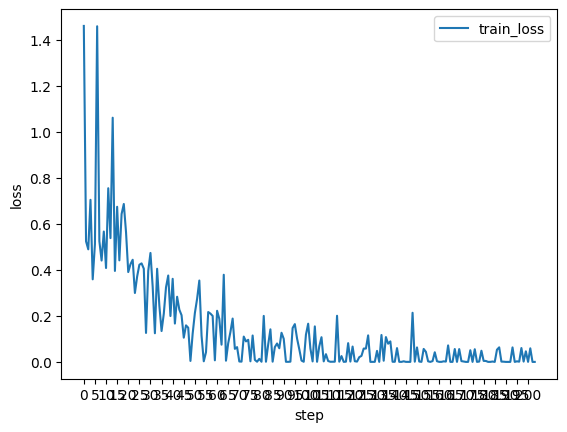

In [48]:
plot_loss(train_loss)

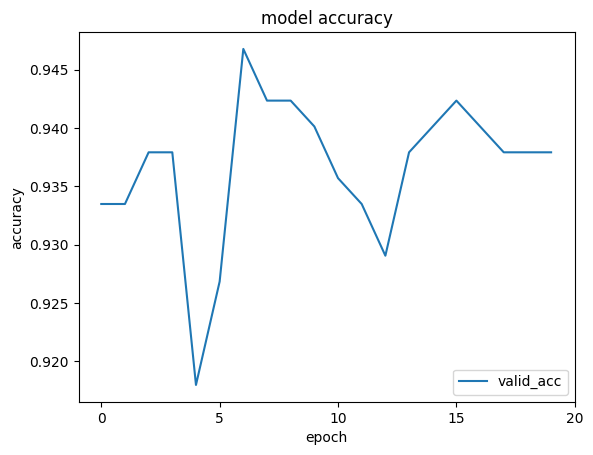

In [49]:
plot_metrics(eval_acc)

In [50]:
base_folder = CFG.MODEL_SAVE_PATH / 'sate'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [51]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_5,
    eval_dataset=val_dataset_5,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_5).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_5[i]["labels"].item() for i in range(len(val_dataset_5))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9467849223946785


# Lymphadenopathyの学習

In [52]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_lymp'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'lymp',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [53]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_6,
    eval_dataset=val_dataset_6,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.4289, 'grad_norm': 12.9183349609375, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.9035, 'grad_norm': 5.6248579025268555, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.6641, 'grad_norm': 5.34095573425293, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.4785, 'grad_norm': 2.3216381072998047, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.5233, 'grad_norm': 3.153580665588379, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.6303, 'grad_norm': 3.552967071533203, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.1861, 'grad_norm': 2.2455618381500244, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.4133, 'grad_norm': 14.671841621398926, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.332, 'grad_norm': 1.9208357334136963, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.5653, 'grad_norm': 0.3577161431312561, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.08600135892629623, 'eval_accuracy': 0.9733924611973392, 'eval_f1': 0.9739051883272455, 'eval_precision': 0.974782626238173, 'eval_recall': 0.9733924611973392, 'eval_runtime': 3.0957, 'eval_samples_per_second': 145.687, 'eval_steps_per_second': 29.396, 'epoch': 1.0}
{'loss': 0.2465, 'grad_norm': 14.194204330444336, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.2149, 'grad_norm': 0.5113935470581055, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.1841, 'grad_norm': 0.31458938121795654, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.3446, 'grad_norm': 0.3160141110420227, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.1251, 'grad_norm': 19.402828216552734, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.2535, 'grad_norm': 0.08924458920955658, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.4026, 'grad_norm': 0.15285305678844452, 'learning_rate': 9.166666666666666e-0

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.07790941745042801, 'eval_accuracy': 0.9844789356984479, 'eval_f1': 0.984556587138905, 'eval_precision': 0.9846596446260029, 'eval_recall': 0.9844789356984479, 'eval_runtime': 3.1037, 'eval_samples_per_second': 145.311, 'eval_steps_per_second': 29.32, 'epoch': 2.0}
{'loss': 0.0352, 'grad_norm': 0.6011921763420105, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.3857, 'grad_norm': 0.1924159824848175, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.0146, 'grad_norm': 0.062401145696640015, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.4059, 'grad_norm': 0.8113945722579956, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.5051, 'grad_norm': 0.18802061676979065, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.0991, 'grad_norm': 0.21197354793548584, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.0705, 'grad_norm': 1.7034409046173096, 'learning_rate': 8.676470588235295e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.1345694214105606, 'eval_accuracy': 0.9711751662971175, 'eval_f1': 0.9721121190863641, 'eval_precision': 0.9741021042563368, 'eval_recall': 0.9711751662971175, 'eval_runtime': 3.1237, 'eval_samples_per_second': 144.381, 'eval_steps_per_second': 29.132, 'epoch': 3.0}
{'loss': 0.1109, 'grad_norm': 0.07768000662326813, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.0757, 'grad_norm': 0.03300531953573227, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.1712, 'grad_norm': 0.09490116685628891, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.1384, 'grad_norm': 0.10729672014713287, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.4322, 'grad_norm': 8.483734130859375, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.1476, 'grad_norm': 0.23831430077552795, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.0908, 'grad_norm': 61.77265167236328, 'learning_rate': 8.186274509803922e-0

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.08342587202787399, 'eval_accuracy': 0.9800443458980045, 'eval_f1': 0.9803363759034266, 'eval_precision': 0.9808441274848814, 'eval_recall': 0.9800443458980045, 'eval_runtime': 3.1067, 'eval_samples_per_second': 145.171, 'eval_steps_per_second': 29.292, 'epoch': 4.0}
{'loss': 0.4243, 'grad_norm': 0.20182038843631744, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.0266, 'grad_norm': 0.08705613762140274, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.1686, 'grad_norm': 57.55567169189453, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.0763, 'grad_norm': 5.4939398765563965, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.0015, 'grad_norm': 0.01878678984940052, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.1767, 'grad_norm': 1.7410352230072021, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0081, 'grad_norm': 0.05827091261744499, 'learning_rate': 7.69607843137255e-

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.099471315741539, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9764025623038465, 'eval_precision': 0.9782711621233859, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.0307, 'eval_samples_per_second': 148.812, 'eval_steps_per_second': 30.026, 'epoch': 5.0}
{'loss': 0.1088, 'grad_norm': 0.36150869727134705, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0152, 'grad_norm': 0.5255419611930847, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.0325, 'grad_norm': 0.07003675401210785, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.1288, 'grad_norm': 0.4123575687408447, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0592, 'grad_norm': 0.016068994998931885, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.1737, 'grad_norm': 0.04272276163101196, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0852, 'grad_norm': 0.09093543887138367, 'learning_rate': 7.15686274509804e-

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.1332530975341797, 'eval_accuracy': 0.9733924611973392, 'eval_f1': 0.9739051883272455, 'eval_precision': 0.974782626238173, 'eval_recall': 0.9733924611973392, 'eval_runtime': 3.0707, 'eval_samples_per_second': 146.873, 'eval_steps_per_second': 29.635, 'epoch': 6.0}
{'loss': 0.043, 'grad_norm': 0.2560931444168091, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.1053, 'grad_norm': 88.41302490234375, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.0795, 'grad_norm': 0.11564356833696365, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0792, 'grad_norm': 1.937453269958496, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0969, 'grad_norm': 0.007281233556568623, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0003, 'grad_norm': 0.016888296231627464, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0008, 'grad_norm': 0.006066649220883846, 'learning_rate': 6.666666666666667e-

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.12015537917613983, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9759666816597434, 'eval_precision': 0.9765346020850139, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.0977, 'eval_samples_per_second': 145.593, 'eval_steps_per_second': 29.377, 'epoch': 7.0}
{'loss': 0.0028, 'grad_norm': 0.01085831131786108, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0132, 'grad_norm': 0.02166515402495861, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0007, 'grad_norm': 0.015845494344830513, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.0003, 'grad_norm': 0.008069224655628204, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.1676, 'grad_norm': 0.011909842491149902, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0023, 'grad_norm': 0.004009254742413759, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.1517, 'grad_norm': 0.014906644821166992, 'learning_rate': 6.17647058

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.11962314695119858, 'eval_accuracy': 0.9800443458980045, 'eval_f1': 0.9801441834643065, 'eval_precision': 0.9802688667280761, 'eval_recall': 0.9800443458980045, 'eval_runtime': 3.1207, 'eval_samples_per_second': 144.519, 'eval_steps_per_second': 29.16, 'epoch': 8.0}
{'loss': 0.0059, 'grad_norm': 0.003866888815537095, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0009, 'grad_norm': 0.0067354654893279076, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0029, 'grad_norm': 0.00626692920923233, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.0767, 'grad_norm': 0.003041890449821949, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0003, 'grad_norm': 0.012251678854227066, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.1261, 'grad_norm': 0.007412745151668787, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0775, 'grad_norm': 0.008721321821212769, 'learning_rate': 5.68627

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.09475981444120407, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9780461105103662, 'eval_precision': 0.9783616773365801, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1107, 'eval_samples_per_second': 144.984, 'eval_steps_per_second': 29.254, 'epoch': 9.0}
{'loss': 0.0004, 'grad_norm': 0.060966260731220245, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.1187, 'grad_norm': 38.1339111328125, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0907, 'grad_norm': 0.008861850947141647, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.003, 'grad_norm': 0.00427574198693037, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0244, 'grad_norm': 0.15616250038146973, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.0548, 'grad_norm': 0.003373469691723585, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0017, 'grad_norm': 0.019526531919836998, 'learning_rate': 5.1960784313

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.1181543618440628, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9761900362334698, 'eval_precision': 0.9773370578664665, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.005, 'eval_samples_per_second': 150.082, 'eval_steps_per_second': 30.283, 'epoch': 10.0}
{'loss': 0.0005, 'grad_norm': 0.008062719367444515, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0198, 'grad_norm': 0.007322938647121191, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0954, 'grad_norm': 0.0021325869020074606, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0002, 'grad_norm': 0.002579214284196496, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.1385, 'grad_norm': 0.007980828173458576, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0007, 'grad_norm': 0.1769031137228012, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0591, 'grad_norm': 0.005242852494120598, 'learning_rate': 4.656

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.09355298429727554, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9782543236060379, 'eval_precision': 0.9790544493534266, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1207, 'eval_samples_per_second': 144.517, 'eval_steps_per_second': 29.16, 'epoch': 11.0}
{'loss': 0.0613, 'grad_norm': 0.07110577076673508, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0094, 'grad_norm': 0.0024785646237432957, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0937, 'grad_norm': 0.005452954676002264, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0006, 'grad_norm': 0.005420937668532133, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0005, 'grad_norm': 0.008994776755571365, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0002, 'grad_norm': 0.004364031367003918, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0001, 'grad_norm': 0.01155991293489933, 'learning_rate': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.09175601601600647, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1009, 'eval_samples_per_second': 145.444, 'eval_steps_per_second': 29.347, 'epoch': 12.0}
{'loss': 0.044, 'grad_norm': 0.006776156835258007, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.1214, 'grad_norm': 0.0022171225864440203, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0059, 'grad_norm': 0.004958897363394499, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0013, 'grad_norm': 0.002883892273530364, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0906, 'grad_norm': 0.0033274260349571705, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0003, 'grad_norm': 0.008719058707356453, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0002, 'grad_norm': 0.017292555421590805, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.11433733999729156, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9782543236060379, 'eval_precision': 0.9790544493534266, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1267, 'eval_samples_per_second': 144.242, 'eval_steps_per_second': 29.104, 'epoch': 13.0}
{'loss': 0.0012, 'grad_norm': 0.004401127342134714, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0001, 'grad_norm': 0.003760011401027441, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0001, 'grad_norm': 0.0046790544874966145, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0003, 'grad_norm': 0.007526239845901728, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0724, 'grad_norm': 0.0029041795060038567, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.1676, 'grad_norm': 0.004080191720277071, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0002, 'grad_norm': 0.003107696771621704, 'learning_r

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.07529532164335251, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.0937, 'eval_samples_per_second': 145.781, 'eval_steps_per_second': 29.415, 'epoch': 14.0}
{'loss': 0.0004, 'grad_norm': 0.013093601912260056, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0001, 'grad_norm': 0.0015409954357892275, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.126, 'grad_norm': 0.0034177631605416536, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0002, 'grad_norm': 0.004509993363171816, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0002, 'grad_norm': 0.003978510852903128, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.002, 'grad_norm': 0.002765149809420109, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0018, 'grad_norm': 0.2603512704372406, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.07032595574855804, 'eval_accuracy': 0.9844789356984479, 'eval_f1': 0.984399256304812, 'eval_precision': 0.9843459788907055, 'eval_recall': 0.9844789356984479, 'eval_runtime': 3.1837, 'eval_samples_per_second': 141.659, 'eval_steps_per_second': 28.583, 'epoch': 15.0}
{'loss': 0.0002, 'grad_norm': 0.0024986325297504663, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0701, 'grad_norm': 9.310003280639648, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0001, 'grad_norm': 0.009814508259296417, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0001, 'grad_norm': 0.0017302670748904347, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0002, 'grad_norm': 0.008526433259248734, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0002, 'grad_norm': 0.0026053613983094692, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.1228, 'grad_norm': 0.0038341106846928596, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06544864922761917, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1807, 'eval_samples_per_second': 141.793, 'eval_steps_per_second': 28.61, 'epoch': 16.0}
{'loss': 0.0004, 'grad_norm': 0.005245596636086702, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0003, 'grad_norm': 0.02053690515458584, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0001, 'grad_norm': 0.0023246167693287134, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0001, 'grad_norm': 0.0033699257764965296, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0025, 'grad_norm': 0.8952703475952148, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0001, 'grad_norm': 0.0017265850910916924, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0201, 'grad_norm': 0.0018607820384204388, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06749165803194046, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1287, 'eval_samples_per_second': 144.15, 'eval_steps_per_second': 29.086, 'epoch': 17.0}
{'loss': 0.0001, 'grad_norm': 0.052334628999233246, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0238, 'grad_norm': 0.0026839643251150846, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0001, 'grad_norm': 0.0012615055311471224, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0003, 'grad_norm': 0.0013537012273445725, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0001, 'grad_norm': 0.01206081174314022, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0004, 'grad_norm': 0.0017377574695274234, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0002, 'grad_norm': 0.07631807774305344, 'learning_

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06496172398328781, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1107, 'eval_samples_per_second': 144.984, 'eval_steps_per_second': 29.254, 'epoch': 18.0}
{'loss': 0.0003, 'grad_norm': 0.003686012700200081, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0005, 'grad_norm': 0.004604659043252468, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0001, 'grad_norm': 0.0034434248227626085, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0781, 'grad_norm': 0.0015443529700860381, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0349, 'grad_norm': 0.003631004597991705, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0005, 'grad_norm': 0.0018095184350386262, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0003, 'grad_norm': 0.0012952443212270737, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06678641587495804, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1247, 'eval_samples_per_second': 144.334, 'eval_steps_per_second': 29.123, 'epoch': 19.0}
{'loss': 0.0153, 'grad_norm': 7.9999213218688965, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0022705683950334787, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.04, 'grad_norm': 6.2997541427612305, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0006, 'grad_norm': 0.0021436007227748632, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0005, 'grad_norm': 0.001586395432241261, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0004, 'grad_norm': 0.0015472237719222903, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0788, 'grad_norm': 0.012839481234550476, 'learning_rate'

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.06324253231287003, 'eval_accuracy': 0.9822616407982262, 'eval_f1': 0.9822616407982262, 'eval_precision': 0.9822616407982262, 'eval_recall': 0.9822616407982262, 'eval_runtime': 3.1585, 'eval_samples_per_second': 142.789, 'eval_steps_per_second': 28.811, 'epoch': 20.0}
{'train_runtime': 764.3837, 'train_samples_per_second': 26.688, 'train_steps_per_second': 2.669, 'train_loss': 0.09621301692843154, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.09621301692843154, metrics={'train_runtime': 764.3837, 'train_samples_per_second': 26.688, 'train_steps_per_second': 2.669, 'total_flos': 1211491648358220.0, 'train_loss': 0.09621301692843154, 'epoch': 20.0})

In [55]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


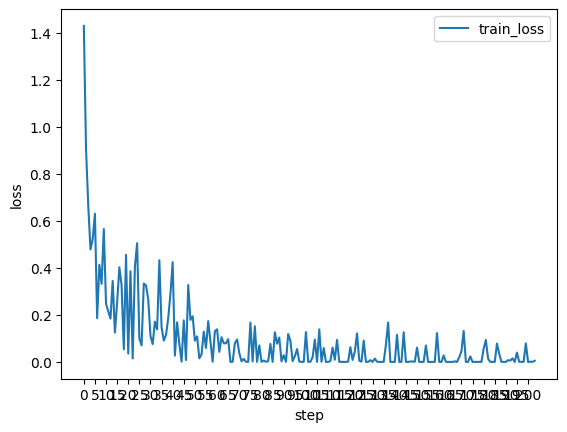

In [56]:
plot_loss(train_loss)

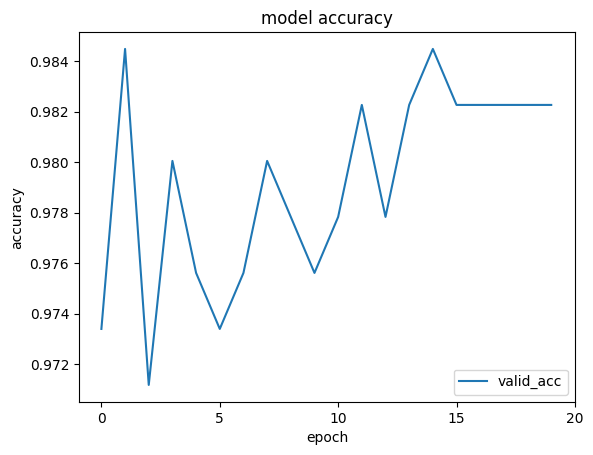

In [57]:
plot_metrics(eval_acc)

In [58]:
base_folder = CFG.MODEL_SAVE_PATH / 'lymp'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [59]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_6,
    eval_dataset=val_dataset_6,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_6).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_6[i]["labels"].item() for i in range(len(val_dataset_6))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9844789356984479


# Pleuralの学習

In [60]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_pleu'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'pleu',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [61]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_7,
    eval_dataset=val_dataset_7,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.4512, 'grad_norm': 16.18829917907715, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.4199, 'grad_norm': 2.4569921493530273, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.2831, 'grad_norm': 0.41027313470840454, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.4449, 'grad_norm': 0.5871168971061707, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.1243, 'grad_norm': 0.09814174473285675, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.2505, 'grad_norm': 8.867293357849121, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.1946, 'grad_norm': 9.277311325073242, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.2751, 'grad_norm': 21.503175735473633, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.2162, 'grad_norm': 0.0736314207315445, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.3139, 'grad_norm': 6.825599193572998, 'learning_

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.16695769131183624, 'eval_accuracy': 0.9068736141906873, 'eval_f1': 0.8625844376837002, 'eval_precision': 0.8224197521152796, 'eval_recall': 0.9068736141906873, 'eval_runtime': 3.0957, 'eval_samples_per_second': 145.687, 'eval_steps_per_second': 29.396, 'epoch': 1.0}
{'loss': 0.2999, 'grad_norm': 41.336177825927734, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.0867, 'grad_norm': 0.06686551123857498, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.1062, 'grad_norm': 4.7216715812683105, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.0148, 'grad_norm': 0.9274177551269531, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.1732, 'grad_norm': 0.03529853746294975, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.0863, 'grad_norm': 0.048203885555267334, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.1051, 'grad_norm': 5.934629917144775, 'learning_rate': 9.166666666666666e-

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2008092999458313, 'eval_accuracy': 0.9689578713968958, 'eval_f1': 0.9674744002326083, 'eval_precision': 0.9678606404038111, 'eval_recall': 0.9689578713968958, 'eval_runtime': 3.1297, 'eval_samples_per_second': 144.104, 'eval_steps_per_second': 29.076, 'epoch': 2.0}
{'loss': 0.047, 'grad_norm': 0.19533997774124146, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.0027, 'grad_norm': 0.2852693498134613, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.0033, 'grad_norm': 0.02008155547082424, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.001, 'grad_norm': 0.013884713873267174, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.0005, 'grad_norm': 0.01040889136493206, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.0007, 'grad_norm': 0.008913962170481682, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.0847, 'grad_norm': 0.008441155776381493, 'learning_rate': 8.676470588235

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.13362248241901398, 'eval_accuracy': 0.9844789356984479, 'eval_f1': 0.9842198661900988, 'eval_precision': 0.9842185401621821, 'eval_recall': 0.9844789356984479, 'eval_runtime': 3.1377, 'eval_samples_per_second': 143.736, 'eval_steps_per_second': 29.002, 'epoch': 3.0}
{'loss': 0.0003, 'grad_norm': 0.008519013412296772, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.0728, 'grad_norm': 0.005675215274095535, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.0009, 'grad_norm': 0.006609004456549883, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.0003, 'grad_norm': 0.005547077860683203, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.0009, 'grad_norm': 0.16490401327610016, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.0004, 'grad_norm': 0.005083470139652491, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.0003, 'grad_norm': 0.00591982202604413, 'learning_rate': 8.18627450

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.22814691066741943, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.1257, 'eval_samples_per_second': 144.288, 'eval_steps_per_second': 29.114, 'epoch': 4.0}
{'loss': 0.0002, 'grad_norm': 0.016723571345210075, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.0003, 'grad_norm': 0.0039115408435463905, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.0003, 'grad_norm': 0.0034180772490799427, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.0002, 'grad_norm': 0.004165010526776314, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.0002, 'grad_norm': 0.00408917386084795, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.0002, 'grad_norm': 0.0035741333849728107, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.0002, 'grad_norm': 0.01629546284675598, 'learning_rate': 7.696078

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2289333939552307, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.0636, 'eval_samples_per_second': 147.213, 'eval_steps_per_second': 29.704, 'epoch': 5.0}
{'loss': 0.0001, 'grad_norm': 0.002971559762954712, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0001, 'grad_norm': 0.003173480974510312, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.0001, 'grad_norm': 0.0031742204446345568, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.0001, 'grad_norm': 0.004405942279845476, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.0001, 'grad_norm': 0.0029585626907646656, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.0002, 'grad_norm': 0.01420068833976984, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0001, 'grad_norm': 0.002251420868560672, 'learning_rate': 7.156862

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23159997165203094, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.1249, 'eval_samples_per_second': 144.325, 'eval_steps_per_second': 29.121, 'epoch': 6.0}
{'loss': 0.0002, 'grad_norm': 0.008650653064250946, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.0001, 'grad_norm': 0.0023701211903244257, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.0001, 'grad_norm': 0.003111394587904215, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.0001, 'grad_norm': 0.007331603206694126, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0001, 'grad_norm': 0.0018569758394733071, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0001, 'grad_norm': 0.0024619726464152336, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0001, 'grad_norm': 0.0017041300889104605, 'learning_rate': 6.666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.22719372808933258, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.1397, 'eval_samples_per_second': 143.645, 'eval_steps_per_second': 28.984, 'epoch': 7.0}
{'loss': 0.0002, 'grad_norm': 0.01229941938072443, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0001, 'grad_norm': 0.007660494185984135, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0001, 'grad_norm': 0.0015418787952512503, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.0001, 'grad_norm': 0.0020633514504879713, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.0001, 'grad_norm': 0.0025109576527029276, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.0001, 'grad_norm': 0.00167129747569561, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.0001, 'grad_norm': 0.0014851895393803716, 'learning_rate': 6.1764

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2291419804096222, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.1127, 'eval_samples_per_second': 144.891, 'eval_steps_per_second': 29.235, 'epoch': 8.0}
{'loss': 0.0001, 'grad_norm': 0.0014906756114214659, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0, 'grad_norm': 0.0017009341390803456, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.0001, 'grad_norm': 0.001405716291628778, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.0001, 'grad_norm': 0.017423829063773155, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0001, 'grad_norm': 0.0014502599369734526, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0001, 'grad_norm': 0.006214139983057976, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0001, 'grad_norm': 0.001049316837452352, 'learning_rate': 5.6862745

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23088961839675903, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.1127, 'eval_samples_per_second': 144.89, 'eval_steps_per_second': 29.235, 'epoch': 9.0}
{'loss': 0.0001, 'grad_norm': 0.001331788720563054, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0, 'grad_norm': 0.001579678151756525, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0, 'grad_norm': 0.001480880076996982, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.0, 'grad_norm': 0.001259528216905892, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0001, 'grad_norm': 0.0011356788454577327, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.0, 'grad_norm': 0.0011102225398644805, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.0001, 'grad_norm': 0.0013987990096211433, 'learning_rate': 5.19607843137255e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23286525905132294, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.9742790574217715, 'eval_precision': 0.9754824472994621, 'eval_recall': 0.975609756097561, 'eval_runtime': 3.0557, 'eval_samples_per_second': 147.594, 'eval_steps_per_second': 29.781, 'epoch': 10.0}
{'loss': 0.0, 'grad_norm': 0.0010905758244916797, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0, 'grad_norm': 0.001051153871230781, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0, 'grad_norm': 0.0030351143795996904, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0001, 'grad_norm': 0.0011899700621142983, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0, 'grad_norm': 0.001165995141491294, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0001, 'grad_norm': 0.0020046038553118706, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0, 'grad_norm': 0.0022273133508861065, 'learning_rate': 4.6568627450

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23306716978549957, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1087, 'eval_samples_per_second': 145.077, 'eval_steps_per_second': 29.273, 'epoch': 11.0}
{'loss': 0.0, 'grad_norm': 0.001151569071225822, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0, 'grad_norm': 0.0010074529564008117, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0001, 'grad_norm': 0.0031223734840750694, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.0001, 'grad_norm': 0.0011261203326284885, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0001, 'grad_norm': 0.0009123123018071055, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0, 'grad_norm': 0.0008661304018460214, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0001, 'grad_norm': 0.004514308180660009, 'learning_rate': 4.1

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23470090329647064, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1236, 'eval_samples_per_second': 144.382, 'eval_steps_per_second': 29.133, 'epoch': 12.0}
{'loss': 0.0, 'grad_norm': 0.0009903470054268837, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0001, 'grad_norm': 0.0009300229721702635, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0, 'grad_norm': 0.007241162471473217, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0001, 'grad_norm': 0.0010033197468146682, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0, 'grad_norm': 0.0008557888213545084, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.0, 'grad_norm': 0.004568805918097496, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0, 'grad_norm': 0.0022974060848355293, 'learning_rate': 3.6764705

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2358214408159256, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.1047, 'eval_samples_per_second': 145.264, 'eval_steps_per_second': 29.311, 'epoch': 13.0}
{'loss': 0.0001, 'grad_norm': 0.0010017951717600226, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0, 'grad_norm': 0.0009898997377604246, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0, 'grad_norm': 0.0007637892267666757, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0, 'grad_norm': 0.0007904309895820916, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.0, 'grad_norm': 0.0008415555348619819, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0, 'grad_norm': 0.0026917157229036093, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0, 'grad_norm': 0.000917347555514425, 'learning_rate': 3.18627450

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23632237315177917, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0977, 'eval_samples_per_second': 145.593, 'eval_steps_per_second': 29.377, 'epoch': 14.0}
{'loss': 0.0, 'grad_norm': 0.0009970449609681964, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0, 'grad_norm': 0.0008342636283487082, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0, 'grad_norm': 0.0008268476813100278, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0, 'grad_norm': 0.0007592985057272017, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0001, 'grad_norm': 0.0035555174108594656, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0, 'grad_norm': 0.005081461742520332, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0, 'grad_norm': 0.0008715722942724824, 'learning_rate': 2.696078

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23711159825325012, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0357, 'eval_samples_per_second': 148.567, 'eval_steps_per_second': 29.977, 'epoch': 15.0}
{'loss': 0.0, 'grad_norm': 0.0010173143818974495, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0, 'grad_norm': 0.0006551241385750473, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0, 'grad_norm': 0.0032057613134384155, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0, 'grad_norm': 0.0008569235214963555, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0, 'grad_norm': 0.001751050935126841, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0, 'grad_norm': 0.0013930810382589698, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0, 'grad_norm': 0.0018521237652748823, 'learning_rate': 2.1568627450980

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23778173327445984, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0804, 'eval_samples_per_second': 146.411, 'eval_steps_per_second': 29.542, 'epoch': 16.0}
{'loss': 0.0, 'grad_norm': 0.0008515562512911856, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0, 'grad_norm': 0.000979563337750733, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0, 'grad_norm': 0.0007448071264661849, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0, 'grad_norm': 0.0007444961229339242, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0, 'grad_norm': 0.0006549492827616632, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0, 'grad_norm': 0.0007323613972403109, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0, 'grad_norm': 0.0019380490994080901, 'learning_rate': 1.6666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23860566318035126, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0972, 'eval_samples_per_second': 145.616, 'eval_steps_per_second': 29.381, 'epoch': 17.0}
{'loss': 0.0, 'grad_norm': 0.0007190116448327899, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0, 'grad_norm': 0.0006740153185091913, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0, 'grad_norm': 0.00064164272043854, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0, 'grad_norm': 0.0006302029360085726, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0, 'grad_norm': 0.0037699067033827305, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0, 'grad_norm': 0.000648468267172575, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0, 'grad_norm': 0.0005935828085057437, 'learning_rate': 1.1764705882

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2390330582857132, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0927, 'eval_samples_per_second': 145.828, 'eval_steps_per_second': 29.424, 'epoch': 18.0}
{'loss': 0.0, 'grad_norm': 0.0013542379019781947, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0, 'grad_norm': 0.0006651865551248193, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0, 'grad_norm': 0.0006286835414357483, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0, 'grad_norm': 0.002573059406131506, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0, 'grad_norm': 0.000755511864554137, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0, 'grad_norm': 0.0006923449691385031, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0, 'grad_norm': 0.0005687335506081581, 'learning_rate': 6.862745098039217e

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.2391977310180664, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0967, 'eval_samples_per_second': 145.64, 'eval_steps_per_second': 29.386, 'epoch': 19.0}
{'loss': 0.0, 'grad_norm': 0.0007127993740141392, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0, 'grad_norm': 0.0007065762183628976, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0, 'grad_norm': 0.0007680716807954013, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0, 'grad_norm': 0.0007059025228954852, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0, 'grad_norm': 0.002541440771892667, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.0, 'grad_norm': 0.0007038822514005005, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0, 'grad_norm': 0.0007982617826201022, 'learning_rate': 1.96078431372

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.23929421603679657, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.9767674287375773, 'eval_precision': 0.977688176835602, 'eval_recall': 0.9778270509977827, 'eval_runtime': 3.0607, 'eval_samples_per_second': 147.351, 'eval_steps_per_second': 29.731, 'epoch': 20.0}
{'train_runtime': 764.8251, 'train_samples_per_second': 26.673, 'train_steps_per_second': 2.667, 'train_loss': 0.025372195135994344, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.025372195135994344, metrics={'train_runtime': 764.8251, 'train_samples_per_second': 26.673, 'train_steps_per_second': 2.667, 'total_flos': 1211491648358220.0, 'train_loss': 0.025372195135994344, 'epoch': 20.0})

In [63]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


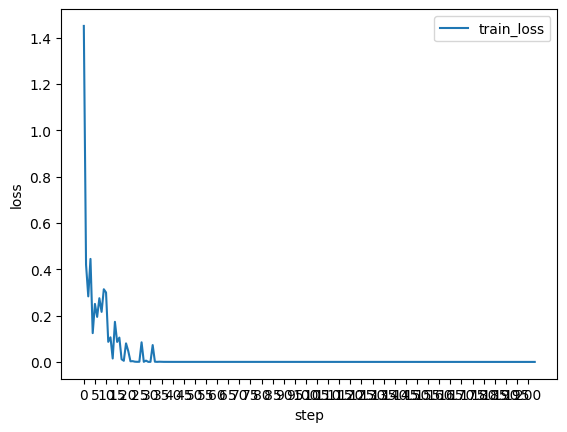

In [64]:
plot_loss(train_loss)

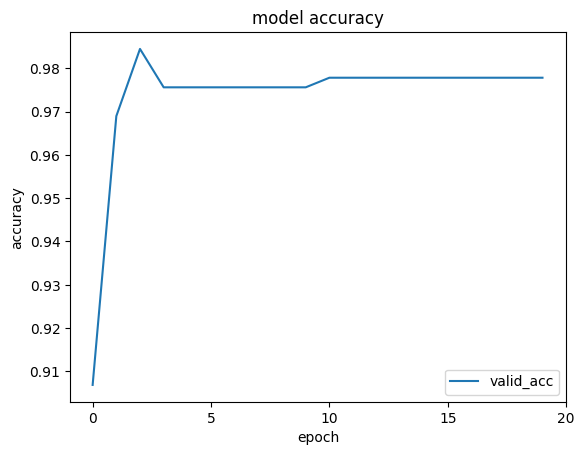

In [65]:
plot_metrics(eval_acc)

In [66]:
base_folder = CFG.MODEL_SAVE_PATH / 'pleu'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [67]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_7,
    eval_dataset=val_dataset_7,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_7).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_7[i]["labels"].item() for i in range(len(val_dataset_7))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9844789356984479


# Distantの学習

In [68]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy="epoch",
    learning_rate=CFG.LEARNING_RATE,
    lr_scheduler_type='linear',
    per_device_train_batch_size=CFG.BATCH_SIZE,
    per_device_eval_batch_size=CFG.BATCH_SIZE,
    gradient_accumulation_steps=2, # 勾配の累積ステップ数。メモリ不足の場合は増やす。
    num_train_epochs=CFG.EPOCHS,
    weight_decay=0.01, # 正則化
    fp16=False, # 高速化. NVIDIA GPUのみ
    logging_dir= Path('./logs_dist'),
    logging_steps=CFG.STEPS,
    save_strategy="epoch",
    output_dir=CFG.MODEL_SAVE_PATH / 'dist',
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model=CFG.METRIC,
    greater_is_better=True,
    save_safetensors=True, # モデルの保存形式
    push_to_hub=False,
    seed=CFG.SEED,
    data_seed=CFG.SEED,
)

In [69]:
config = AutoConfig.from_pretrained(CFG.MODEL_PATH)
config.num_labels=CFG.TARGET_CLASS_NUM
model = AutoModelForSequenceClassification.from_pretrained(CFG.MODEL_PATH, config=config)
model.classifier

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1024, out_features=2, bias=True)

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_8,
    eval_dataset=val_dataset_8,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/2040 [00:00<?, ?it/s]

{'loss': 1.4471, 'grad_norm': 16.252307891845703, 'learning_rate': 9.950980392156863e-06, 'epoch': 0.1}
{'loss': 0.8158, 'grad_norm': 4.377446174621582, 'learning_rate': 9.901960784313727e-06, 'epoch': 0.2}
{'loss': 0.7052, 'grad_norm': 8.456608772277832, 'learning_rate': 9.852941176470589e-06, 'epoch': 0.29}
{'loss': 0.6167, 'grad_norm': 6.494632720947266, 'learning_rate': 9.803921568627451e-06, 'epoch': 0.39}
{'loss': 0.6652, 'grad_norm': 7.066526412963867, 'learning_rate': 9.754901960784315e-06, 'epoch': 0.49}
{'loss': 0.4573, 'grad_norm': 6.969210147857666, 'learning_rate': 9.705882352941177e-06, 'epoch': 0.59}
{'loss': 0.48, 'grad_norm': 1.976511836051941, 'learning_rate': 9.65686274509804e-06, 'epoch': 0.69}
{'loss': 0.5164, 'grad_norm': 1.908271312713623, 'learning_rate': 9.607843137254903e-06, 'epoch': 0.78}
{'loss': 0.4993, 'grad_norm': 5.18281364440918, 'learning_rate': 9.558823529411766e-06, 'epoch': 0.88}
{'loss': 0.5267, 'grad_norm': 16.76256561279297, 'learning_rate': 9.5

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.29589924216270447, 'eval_accuracy': 0.8957871396895787, 'eval_f1': 0.8465450396130756, 'eval_precision': 0.8024345996332367, 'eval_recall': 0.8957871396895787, 'eval_runtime': 3.0908, 'eval_samples_per_second': 145.916, 'eval_steps_per_second': 29.442, 'epoch': 1.0}
{'loss': 0.5448, 'grad_norm': 13.695904731750488, 'learning_rate': 9.46078431372549e-06, 'epoch': 1.08}
{'loss': 0.3587, 'grad_norm': 77.85458374023438, 'learning_rate': 9.411764705882354e-06, 'epoch': 1.18}
{'loss': 0.6426, 'grad_norm': 38.902801513671875, 'learning_rate': 9.362745098039216e-06, 'epoch': 1.27}
{'loss': 0.3989, 'grad_norm': 3.2753281593322754, 'learning_rate': 9.31372549019608e-06, 'epoch': 1.37}
{'loss': 0.073, 'grad_norm': 0.23016609251499176, 'learning_rate': 9.264705882352942e-06, 'epoch': 1.47}
{'loss': 0.192, 'grad_norm': 0.43186676502227783, 'learning_rate': 9.215686274509804e-06, 'epoch': 1.57}
{'loss': 0.1711, 'grad_norm': 20.095151901245117, 'learning_rate': 9.166666666666666e-06, 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4085003435611725, 'eval_accuracy': 0.9157427937915743, 'eval_f1': 0.8890478287208956, 'eval_precision': 0.9229866259995384, 'eval_recall': 0.9157427937915743, 'eval_runtime': 3.1187, 'eval_samples_per_second': 144.612, 'eval_steps_per_second': 29.179, 'epoch': 2.0}
{'loss': 0.1598, 'grad_norm': 0.1008862555027008, 'learning_rate': 8.970588235294119e-06, 'epoch': 2.06}
{'loss': 0.2166, 'grad_norm': 0.2639690339565277, 'learning_rate': 8.921568627450982e-06, 'epoch': 2.16}
{'loss': 0.0237, 'grad_norm': 20.795528411865234, 'learning_rate': 8.872549019607843e-06, 'epoch': 2.25}
{'loss': 0.2714, 'grad_norm': 30.348249435424805, 'learning_rate': 8.823529411764707e-06, 'epoch': 2.35}
{'loss': 0.2934, 'grad_norm': 0.1282038688659668, 'learning_rate': 8.774509803921569e-06, 'epoch': 2.45}
{'loss': 0.0757, 'grad_norm': 0.030089931562542915, 'learning_rate': 8.725490196078433e-06, 'epoch': 2.55}
{'loss': 0.1653, 'grad_norm': 0.052265483886003494, 'learning_rate': 8.676470588235295

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.26095110177993774, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9345997394181543, 'eval_precision': 0.9335399218750227, 'eval_recall': 0.9379157427937915, 'eval_runtime': 3.1072, 'eval_samples_per_second': 145.148, 'eval_steps_per_second': 29.287, 'epoch': 3.0}
{'loss': 0.4212, 'grad_norm': 75.25048065185547, 'learning_rate': 8.480392156862745e-06, 'epoch': 3.04}
{'loss': 0.183, 'grad_norm': 0.20500768721103668, 'learning_rate': 8.43137254901961e-06, 'epoch': 3.14}
{'loss': 0.0093, 'grad_norm': 0.2941440939903259, 'learning_rate': 8.382352941176472e-06, 'epoch': 3.24}
{'loss': 0.009, 'grad_norm': 0.030895626172423363, 'learning_rate': 8.333333333333334e-06, 'epoch': 3.33}
{'loss': 0.0852, 'grad_norm': 0.05615345388650894, 'learning_rate': 8.284313725490198e-06, 'epoch': 3.43}
{'loss': 0.0481, 'grad_norm': 3.9644665718078613, 'learning_rate': 8.23529411764706e-06, 'epoch': 3.53}
{'loss': 0.1483, 'grad_norm': 36.3125, 'learning_rate': 8.186274509803922e-06, 'epoch': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.32372838258743286, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9261732607711448, 'eval_precision': 0.9324289764613635, 'eval_recall': 0.9356984478935698, 'eval_runtime': 3.1007, 'eval_samples_per_second': 145.452, 'eval_steps_per_second': 29.348, 'epoch': 4.0}
{'loss': 0.093, 'grad_norm': 0.15173569321632385, 'learning_rate': 7.990196078431374e-06, 'epoch': 4.02}
{'loss': 0.006, 'grad_norm': 0.0370950810611248, 'learning_rate': 7.941176470588236e-06, 'epoch': 4.12}
{'loss': 0.2452, 'grad_norm': 0.028522858396172523, 'learning_rate': 7.892156862745098e-06, 'epoch': 4.22}
{'loss': 0.0805, 'grad_norm': 0.367100328207016, 'learning_rate': 7.84313725490196e-06, 'epoch': 4.31}
{'loss': 0.0988, 'grad_norm': 0.07555927336215973, 'learning_rate': 7.794117647058825e-06, 'epoch': 4.41}
{'loss': 0.0156, 'grad_norm': 10.076126098632812, 'learning_rate': 7.745098039215687e-06, 'epoch': 4.51}
{'loss': 0.1, 'grad_norm': 0.02757738158106804, 'learning_rate': 7.69607843137255e-06, 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.364959180355072, 'eval_accuracy': 0.9379157427937915, 'eval_f1': 0.9330120683423159, 'eval_precision': 0.9328905816243895, 'eval_recall': 0.9379157427937915, 'eval_runtime': 3.0386, 'eval_samples_per_second': 148.426, 'eval_steps_per_second': 29.948, 'epoch': 5.0}
{'loss': 0.1074, 'grad_norm': 0.2635605037212372, 'learning_rate': 7.450980392156863e-06, 'epoch': 5.1}
{'loss': 0.0639, 'grad_norm': 1.6502598524093628, 'learning_rate': 7.401960784313726e-06, 'epoch': 5.2}
{'loss': 0.0414, 'grad_norm': 0.03060745820403099, 'learning_rate': 7.352941176470589e-06, 'epoch': 5.29}
{'loss': 0.2919, 'grad_norm': 0.034451697021722794, 'learning_rate': 7.3039215686274515e-06, 'epoch': 5.39}
{'loss': 0.1115, 'grad_norm': 0.016356440261006355, 'learning_rate': 7.2549019607843145e-06, 'epoch': 5.49}
{'loss': 0.1105, 'grad_norm': 0.10878859460353851, 'learning_rate': 7.205882352941177e-06, 'epoch': 5.59}
{'loss': 0.0016, 'grad_norm': 0.06414207816123962, 'learning_rate': 7.1568627450980

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.36904311180114746, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.9312647600283072, 'eval_precision': 0.9388690411281375, 'eval_recall': 0.9401330376940134, 'eval_runtime': 3.0977, 'eval_samples_per_second': 145.593, 'eval_steps_per_second': 29.377, 'epoch': 6.0}
{'loss': 0.0022, 'grad_norm': 0.6641671061515808, 'learning_rate': 6.96078431372549e-06, 'epoch': 6.08}
{'loss': 0.067, 'grad_norm': 0.01097649522125721, 'learning_rate': 6.911764705882353e-06, 'epoch': 6.18}
{'loss': 0.007, 'grad_norm': 0.009862251579761505, 'learning_rate': 6.862745098039216e-06, 'epoch': 6.27}
{'loss': 0.062, 'grad_norm': 0.0592544861137867, 'learning_rate': 6.813725490196079e-06, 'epoch': 6.37}
{'loss': 0.0145, 'grad_norm': 0.007981398142874241, 'learning_rate': 6.764705882352942e-06, 'epoch': 6.47}
{'loss': 0.0005, 'grad_norm': 0.03247949481010437, 'learning_rate': 6.715686274509804e-06, 'epoch': 6.57}
{'loss': 0.0061, 'grad_norm': 0.009970081970095634, 'learning_rate': 6.66666666666666

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.41383883357048035, 'eval_accuracy': 0.9401330376940134, 'eval_f1': 0.9322803029783976, 'eval_precision': 0.9373898124830693, 'eval_recall': 0.9401330376940134, 'eval_runtime': 3.083, 'eval_samples_per_second': 146.285, 'eval_steps_per_second': 29.516, 'epoch': 7.0}
{'loss': 0.1054, 'grad_norm': 0.011499679647386074, 'learning_rate': 6.470588235294119e-06, 'epoch': 7.06}
{'loss': 0.0013, 'grad_norm': 0.010206807404756546, 'learning_rate': 6.421568627450982e-06, 'epoch': 7.16}
{'loss': 0.0352, 'grad_norm': 0.005475747399032116, 'learning_rate': 6.372549019607843e-06, 'epoch': 7.25}
{'loss': 0.1944, 'grad_norm': 0.05426656827330589, 'learning_rate': 6.323529411764706e-06, 'epoch': 7.35}
{'loss': 0.007, 'grad_norm': 0.10592435300350189, 'learning_rate': 6.274509803921569e-06, 'epoch': 7.45}
{'loss': 0.2462, 'grad_norm': 0.0048285434022545815, 'learning_rate': 6.225490196078432e-06, 'epoch': 7.55}
{'loss': 0.1238, 'grad_norm': 0.005824056454002857, 'learning_rate': 6.1764705

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4694974720478058, 'eval_accuracy': 0.926829268292683, 'eval_f1': 0.9132689117578457, 'eval_precision': 0.922016297889197, 'eval_recall': 0.926829268292683, 'eval_runtime': 3.0937, 'eval_samples_per_second': 145.781, 'eval_steps_per_second': 29.415, 'epoch': 8.0}
{'loss': 0.1945, 'grad_norm': 0.023909620940685272, 'learning_rate': 5.980392156862746e-06, 'epoch': 8.04}
{'loss': 0.0003, 'grad_norm': 0.014224095270037651, 'learning_rate': 5.931372549019609e-06, 'epoch': 8.14}
{'loss': 0.1057, 'grad_norm': 0.032242629677057266, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.24}
{'loss': 0.0428, 'grad_norm': 0.010177191346883774, 'learning_rate': 5.833333333333334e-06, 'epoch': 8.33}
{'loss': 0.0005, 'grad_norm': 0.025743896141648293, 'learning_rate': 5.784313725490197e-06, 'epoch': 8.43}
{'loss': 0.0336, 'grad_norm': 0.005062588956207037, 'learning_rate': 5.735294117647059e-06, 'epoch': 8.53}
{'loss': 0.0004, 'grad_norm': 0.034395042806863785, 'learning_rate': 5.68627450

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4388737976551056, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9204850465207566, 'eval_precision': 0.9343812537008943, 'eval_recall': 0.9334811529933481, 'eval_runtime': 3.0777, 'eval_samples_per_second': 146.539, 'eval_steps_per_second': 29.568, 'epoch': 9.0}
{'loss': 0.1219, 'grad_norm': 0.048205722123384476, 'learning_rate': 5.4901960784313735e-06, 'epoch': 9.02}
{'loss': 0.0652, 'grad_norm': 13.185114860534668, 'learning_rate': 5.441176470588236e-06, 'epoch': 9.12}
{'loss': 0.0019, 'grad_norm': 0.006370034068822861, 'learning_rate': 5.392156862745098e-06, 'epoch': 9.22}
{'loss': 0.0018, 'grad_norm': 0.012757472693920135, 'learning_rate': 5.343137254901961e-06, 'epoch': 9.31}
{'loss': 0.0194, 'grad_norm': 0.00597975542768836, 'learning_rate': 5.294117647058824e-06, 'epoch': 9.41}
{'loss': 0.2085, 'grad_norm': 0.024203091859817505, 'learning_rate': 5.245098039215687e-06, 'epoch': 9.51}
{'loss': 0.091, 'grad_norm': 0.017722180113196373, 'learning_rate': 5.19607843

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4362618923187256, 'eval_accuracy': 0.9312638580931264, 'eval_f1': 0.9198431131828032, 'eval_precision': 0.9273228619126624, 'eval_recall': 0.9312638580931264, 'eval_runtime': 3.028, 'eval_samples_per_second': 148.943, 'eval_steps_per_second': 30.053, 'epoch': 10.0}
{'loss': 0.0417, 'grad_norm': 0.009806714951992035, 'learning_rate': 4.9509803921568634e-06, 'epoch': 10.1}
{'loss': 0.0652, 'grad_norm': 0.03319648280739784, 'learning_rate': 4.901960784313726e-06, 'epoch': 10.2}
{'loss': 0.0214, 'grad_norm': 0.015191766433417797, 'learning_rate': 4.852941176470589e-06, 'epoch': 10.29}
{'loss': 0.0731, 'grad_norm': 0.009476176463067532, 'learning_rate': 4.803921568627452e-06, 'epoch': 10.39}
{'loss': 0.0538, 'grad_norm': 0.008166949264705181, 'learning_rate': 4.754901960784314e-06, 'epoch': 10.49}
{'loss': 0.0305, 'grad_norm': 4.2267022132873535, 'learning_rate': 4.705882352941177e-06, 'epoch': 10.59}
{'loss': 0.0005, 'grad_norm': 0.007411993108689785, 'learning_rate': 4.656

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.481418251991272, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.921801179116704, 'eval_precision': 0.9317446403095864, 'eval_recall': 0.9334811529933481, 'eval_runtime': 3.0957, 'eval_samples_per_second': 145.687, 'eval_steps_per_second': 29.396, 'epoch': 11.0}
{'loss': 0.0056, 'grad_norm': 0.009409709833562374, 'learning_rate': 4.460784313725491e-06, 'epoch': 11.08}
{'loss': 0.0471, 'grad_norm': 0.003407992422580719, 'learning_rate': 4.411764705882353e-06, 'epoch': 11.18}
{'loss': 0.0533, 'grad_norm': 0.008573072031140327, 'learning_rate': 4.3627450980392164e-06, 'epoch': 11.27}
{'loss': 0.191, 'grad_norm': 0.008707785047590733, 'learning_rate': 4.313725490196079e-06, 'epoch': 11.37}
{'loss': 0.0572, 'grad_norm': 0.022110452875494957, 'learning_rate': 4.264705882352942e-06, 'epoch': 11.47}
{'loss': 0.0679, 'grad_norm': 0.006337976083159447, 'learning_rate': 4.215686274509805e-06, 'epoch': 11.57}
{'loss': 0.0291, 'grad_norm': 0.015489548444747925, 'learning_rate': 4.

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.492999404668808, 'eval_accuracy': 0.9290465631929047, 'eval_f1': 0.9151840496221404, 'eval_precision': 0.9268227849742613, 'eval_recall': 0.9290465631929047, 'eval_runtime': 3.0977, 'eval_samples_per_second': 145.593, 'eval_steps_per_second': 29.377, 'epoch': 12.0}
{'loss': 0.0002, 'grad_norm': 0.005241968668997288, 'learning_rate': 3.970588235294118e-06, 'epoch': 12.06}
{'loss': 0.0022, 'grad_norm': 0.08248712122440338, 'learning_rate': 3.92156862745098e-06, 'epoch': 12.16}
{'loss': 0.0824, 'grad_norm': 0.013549994677305222, 'learning_rate': 3.872549019607843e-06, 'epoch': 12.25}
{'loss': 0.0558, 'grad_norm': 0.060079511255025864, 'learning_rate': 3.8235294117647055e-06, 'epoch': 12.35}
{'loss': 0.0372, 'grad_norm': 0.005550437141209841, 'learning_rate': 3.774509803921569e-06, 'epoch': 12.45}
{'loss': 0.003, 'grad_norm': 0.0035630858037620783, 'learning_rate': 3.7254901960784316e-06, 'epoch': 12.55}
{'loss': 0.0898, 'grad_norm': 0.008828869089484215, 'learning_rate': 3

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4848890006542206, 'eval_accuracy': 0.9312638580931264, 'eval_f1': 0.9185253413482793, 'eval_precision': 0.9293053333401928, 'eval_recall': 0.9312638580931264, 'eval_runtime': 3.0769, 'eval_samples_per_second': 146.574, 'eval_steps_per_second': 29.575, 'epoch': 13.0}
{'loss': 0.0142, 'grad_norm': 0.011286302469670773, 'learning_rate': 3.480392156862745e-06, 'epoch': 13.04}
{'loss': 0.0078, 'grad_norm': 0.031072497367858887, 'learning_rate': 3.431372549019608e-06, 'epoch': 13.14}
{'loss': 0.0002, 'grad_norm': 0.002075072843581438, 'learning_rate': 3.382352941176471e-06, 'epoch': 13.24}
{'loss': 0.0021, 'grad_norm': 0.09028733521699905, 'learning_rate': 3.3333333333333333e-06, 'epoch': 13.33}
{'loss': 0.1285, 'grad_norm': 0.0024085091426968575, 'learning_rate': 3.2843137254901964e-06, 'epoch': 13.43}
{'loss': 0.0627, 'grad_norm': 0.010784649290144444, 'learning_rate': 3.2352941176470594e-06, 'epoch': 13.53}
{'loss': 0.0594, 'grad_norm': 0.002158168237656355, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4594230651855469, 'eval_accuracy': 0.9312638580931264, 'eval_f1': 0.9198431131828032, 'eval_precision': 0.9273228619126624, 'eval_recall': 0.9312638580931264, 'eval_runtime': 3.0847, 'eval_samples_per_second': 146.206, 'eval_steps_per_second': 29.501, 'epoch': 14.0}
{'loss': 0.0002, 'grad_norm': 0.0036465045996010303, 'learning_rate': 2.990196078431373e-06, 'epoch': 14.02}
{'loss': 0.0016, 'grad_norm': 0.004356265068054199, 'learning_rate': 2.9411764705882355e-06, 'epoch': 14.12}
{'loss': 0.0047, 'grad_norm': 0.0037803344894200563, 'learning_rate': 2.8921568627450985e-06, 'epoch': 14.22}
{'loss': 0.0001, 'grad_norm': 0.002750157378613949, 'learning_rate': 2.843137254901961e-06, 'epoch': 14.31}
{'loss': 0.0451, 'grad_norm': 0.007204720284789801, 'learning_rate': 2.7941176470588237e-06, 'epoch': 14.41}
{'loss': 0.0769, 'grad_norm': 0.007935008965432644, 'learning_rate': 2.7450980392156867e-06, 'epoch': 14.51}
{'loss': 0.0638, 'grad_norm': 0.583604097366333, 'learning_rate

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4301605522632599, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9261732607711448, 'eval_precision': 0.9324289764613635, 'eval_recall': 0.9356984478935698, 'eval_runtime': 3.0373, 'eval_samples_per_second': 148.486, 'eval_steps_per_second': 29.961, 'epoch': 15.0}
{'loss': 0.0052, 'grad_norm': 0.00918622873723507, 'learning_rate': 2.450980392156863e-06, 'epoch': 15.1}
{'loss': 0.0411, 'grad_norm': 7.647362232208252, 'learning_rate': 2.401960784313726e-06, 'epoch': 15.2}
{'loss': 0.0351, 'grad_norm': 0.00265316478908062, 'learning_rate': 2.3529411764705885e-06, 'epoch': 15.29}
{'loss': 0.0002, 'grad_norm': 0.013030863367021084, 'learning_rate': 2.303921568627451e-06, 'epoch': 15.39}
{'loss': 0.0309, 'grad_norm': 0.03507517650723457, 'learning_rate': 2.254901960784314e-06, 'epoch': 15.49}
{'loss': 0.0054, 'grad_norm': 0.0017848256975412369, 'learning_rate': 2.2058823529411767e-06, 'epoch': 15.59}
{'loss': 0.0538, 'grad_norm': 0.003133903257548809, 'learning_rate': 2.156

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.44924792647361755, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9261732607711448, 'eval_precision': 0.9324289764613635, 'eval_recall': 0.9356984478935698, 'eval_runtime': 3.0917, 'eval_samples_per_second': 145.875, 'eval_steps_per_second': 29.434, 'epoch': 16.0}
{'loss': 0.037, 'grad_norm': 0.0064271483570337296, 'learning_rate': 1.96078431372549e-06, 'epoch': 16.08}
{'loss': 0.0047, 'grad_norm': 0.003948845900595188, 'learning_rate': 1.9117647058823528e-06, 'epoch': 16.18}
{'loss': 0.0001, 'grad_norm': 0.006837520748376846, 'learning_rate': 1.8627450980392158e-06, 'epoch': 16.27}
{'loss': 0.0001, 'grad_norm': 0.0034509615506976843, 'learning_rate': 1.8137254901960786e-06, 'epoch': 16.37}
{'loss': 0.0366, 'grad_norm': 0.03337604179978371, 'learning_rate': 1.7647058823529414e-06, 'epoch': 16.47}
{'loss': 0.0001, 'grad_norm': 0.002251880941912532, 'learning_rate': 1.715686274509804e-06, 'epoch': 16.57}
{'loss': 0.0792, 'grad_norm': 0.007002949248999357, 'learning_rat

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4572373330593109, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9261732607711448, 'eval_precision': 0.9324289764613635, 'eval_recall': 0.9356984478935698, 'eval_runtime': 3.1126, 'eval_samples_per_second': 144.895, 'eval_steps_per_second': 29.236, 'epoch': 17.0}
{'loss': 0.0441, 'grad_norm': 0.5283598899841309, 'learning_rate': 1.4705882352941177e-06, 'epoch': 17.06}
{'loss': 0.0376, 'grad_norm': 0.052941933274269104, 'learning_rate': 1.4215686274509805e-06, 'epoch': 17.16}
{'loss': 0.0002, 'grad_norm': 0.0023991467896848917, 'learning_rate': 1.3725490196078434e-06, 'epoch': 17.25}
{'loss': 0.0094, 'grad_norm': 0.01047807652503252, 'learning_rate': 1.323529411764706e-06, 'epoch': 17.35}
{'loss': 0.0001, 'grad_norm': 0.010504967533051968, 'learning_rate': 1.2745098039215686e-06, 'epoch': 17.45}
{'loss': 0.0333, 'grad_norm': 0.008204436860978603, 'learning_rate': 1.2254901960784314e-06, 'epoch': 17.55}
{'loss': 0.0051, 'grad_norm': 1.4390928745269775, 'learning_rate':

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4726915955543518, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9230373285251334, 'eval_precision': 0.9298970818380933, 'eval_recall': 0.9334811529933481, 'eval_runtime': 2.9822, 'eval_samples_per_second': 151.229, 'eval_steps_per_second': 30.514, 'epoch': 18.0}
{'loss': 0.0001, 'grad_norm': 0.002015900332480669, 'learning_rate': 9.80392156862745e-07, 'epoch': 18.04}
{'loss': 0.0313, 'grad_norm': 0.00594523549079895, 'learning_rate': 9.313725490196079e-07, 'epoch': 18.14}
{'loss': 0.0029, 'grad_norm': 0.009537236765027046, 'learning_rate': 8.823529411764707e-07, 'epoch': 18.24}
{'loss': 0.0036, 'grad_norm': 0.003104639472439885, 'learning_rate': 8.333333333333333e-07, 'epoch': 18.33}
{'loss': 0.0037, 'grad_norm': 0.0038628943730145693, 'learning_rate': 7.843137254901962e-07, 'epoch': 18.43}
{'loss': 0.0469, 'grad_norm': 0.006166315171867609, 'learning_rate': 7.352941176470589e-07, 'epoch': 18.53}
{'loss': 0.0379, 'grad_norm': 0.014336715452373028, 'learning_rate': 6

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.47302010655403137, 'eval_accuracy': 0.9334811529933481, 'eval_f1': 0.9230373285251334, 'eval_precision': 0.9298970818380933, 'eval_recall': 0.9334811529933481, 'eval_runtime': 3.0012, 'eval_samples_per_second': 150.273, 'eval_steps_per_second': 30.321, 'epoch': 19.0}
{'loss': 0.083, 'grad_norm': 6.161829471588135, 'learning_rate': 4.901960784313725e-07, 'epoch': 19.02}
{'loss': 0.0001, 'grad_norm': 0.0026861117221415043, 'learning_rate': 4.4117647058823536e-07, 'epoch': 19.12}
{'loss': 0.0001, 'grad_norm': 0.01491477619856596, 'learning_rate': 3.921568627450981e-07, 'epoch': 19.22}
{'loss': 0.0368, 'grad_norm': 0.002477898495271802, 'learning_rate': 3.4313725490196084e-07, 'epoch': 19.31}
{'loss': 0.0092, 'grad_norm': 0.006807521916925907, 'learning_rate': 2.9411764705882356e-07, 'epoch': 19.41}
{'loss': 0.03, 'grad_norm': 0.0025019324384629726, 'learning_rate': 2.4509803921568627e-07, 'epoch': 19.51}
{'loss': 0.0042, 'grad_norm': 0.005378019995987415, 'learning_rate': 

  0%|          | 0/91 [00:00<?, ?it/s]

{'eval_loss': 0.4698381721973419, 'eval_accuracy': 0.9356984478935698, 'eval_f1': 0.9261732607711448, 'eval_precision': 0.9324289764613635, 'eval_recall': 0.9356984478935698, 'eval_runtime': 3.0095, 'eval_samples_per_second': 149.857, 'eval_steps_per_second': 30.237, 'epoch': 20.0}
{'train_runtime': 754.8758, 'train_samples_per_second': 27.024, 'train_steps_per_second': 2.702, 'train_loss': 0.1056869949341133, 'epoch': 20.0}


TrainOutput(global_step=2040, training_loss=0.1056869949341133, metrics={'train_runtime': 754.8758, 'train_samples_per_second': 27.024, 'train_steps_per_second': 2.702, 'total_flos': 1211491648358220.0, 'train_loss': 0.1056869949341133, 'epoch': 20.0})

In [71]:
train_loss, eval_acc = [],[]

for log in trainer.state.log_history:
    if 'loss' in log:
         train_loss.append(log['loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])


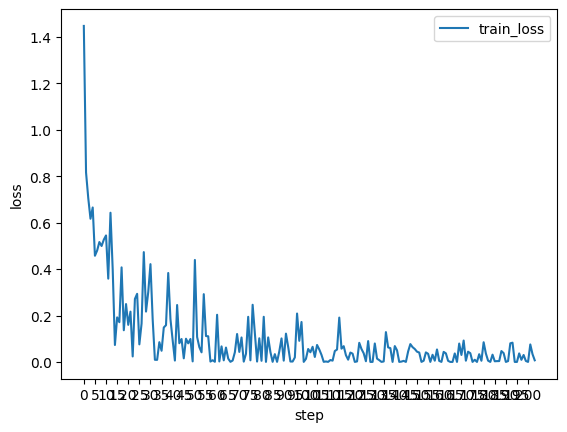

In [72]:
plot_loss(train_loss)

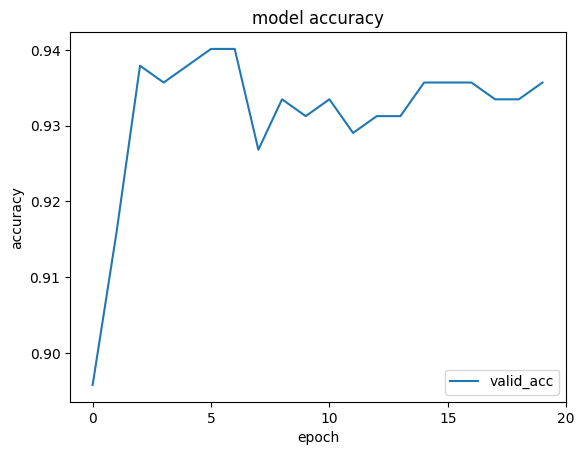

In [73]:
plot_metrics(eval_acc)

In [74]:
base_folder = CFG.MODEL_SAVE_PATH / 'dist'
trained_model_path = [f for f in base_folder.iterdir() if f.is_dir() and "checkpoint-" in f.name][0]
trained_model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

In [75]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    train_dataset=train_dataset_8,
    eval_dataset=val_dataset_8,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

predictions = torch.softmax(torch.tensor(trainer.predict(val_dataset_8).predictions), dim = 1).argmax(axis=1).tolist()
labels = [val_dataset_8[i]["labels"].item() for i in range(len(val_dataset_8))]
print(accuracy_score(labels, predictions))


  0%|          | 0/91 [00:00<?, ?it/s]

0.9401330376940134
